#
Курс «Библиотеки Python для Data Science: продолжение»

Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

# Подключение библиотек и скриптов

In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tabulate

In [9]:
import pandas as pd
import numpy as np
import pickle
import random

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## Вспомогательные функции 

In [10]:
def build_regressor(df, columns, filed):
    # Обучили регрессор.
    X = df[df[filed].notnull()][columns]
    y = df[df[filed].notnull()][filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [11]:
def predict_regressor(df, model, columns, filed):
    # Получили значения для пустых значений.
    X = df[df[filed].isnull()][columns]
    y = model.predict(X)
    return y

In [12]:
def emissions(data):
    # Считаем диапазон за границами которого все выброс.    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [13]:
def build_regressor_outlier(df, columns, filed):
    # Обучили регрессор.
    X = df[columns]
    y = df[filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [14]:
def predict_regressor_outlier(df, model, columns, filed):
    # Получили значения для пустых значений.
    X = df[columns]
    y = model.predict(X)
    return y

In [15]:
def clear_outlier(data, field, columns):
    # Обрабатываем выброс для конкретного поля.
    r_1, r_2 = emissions(data[field])
    if r_1 - r_2 != 0:
        share = round(data[(r_1 > data[field]) | (data[field] > r_2)].size/data.size*100, 2)
        print(f'"{field}"\nОбщая доля выбросов в процентах {share}%\n')
        if share > 5:
            model = build_regressor_outlier(data[(r_1 < data[field]) & (data[field] < r_2)], columns, filed)
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = predict_regressor_outlier(data[(r_1 > data[field]) | (data[field] > r_2)], model, columns, filed)
        else:
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = data[(r_1 < data[field]) & (data[field] < r_2)][field].mode()[0]

In [16]:
def clear_outlier_all(data, columns):
    # Обрабатываем выбросы для всех полей конкретной выборки
    clear_outlier(data, 'Annual Income', columns)
    clear_outlier(data, 'Tax Liens', columns)
    clear_outlier(data, 'Number of Open Accounts', columns)
    clear_outlier(data, 'Years of Credit History', columns)
    clear_outlier(data, 'Maximum Open Credit', columns)
    clear_outlier(data, 'Number of Credit Problems', columns)
    clear_outlier(data, 'Months since last delinquent', columns)
    clear_outlier(data, 'Bankruptcies', columns)
    clear_outlier(data, 'Current Loan Amount', columns)
    clear_outlier(data, 'Current Credit Balance', columns)
    clear_outlier(data, 'Monthly Debt', columns)
    clear_outlier(data, 'Credit Score', columns)

In [17]:
def grouped_by_target(data, field, target):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.countplot(x=field, hue=target, data=data)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.legend(title='Target', loc='upper right')
    plt.show()

In [18]:
def grouped_by_target_kde(data, field, target, n=1000):
    limit_bal_with_target_s = data[[field, target]]
    limit_bal_s = limit_bal_with_target_s[field]
    limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
    limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]
    plt.figure(figsize=(10, 10))
    sns.kdeplot(limit_bal_target_0, shade=True, label='0', color='g')
    sns.kdeplot(limit_bal_target_1, shade=True, label='1', color='r')
    plt.xlabel(field)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.show()

In [19]:
def combine_into_category(df, field, target, var_1, var_2, id, significancy=0.05):
    sample = df.loc[df[field].isin([var_1, var_2]), [id, field, target]]
    table = sample.pivot_table(values=id, index=field, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p > significancy

In [20]:

def combine_into_category_table(df, field, target, id):
    # Определить значения показателя, которые можно собрать в одно значение
    values = df[field].unique()
    values_len = len(values)
    head =[' ']
    head.extend(values)
    result = [head]
    for i in range(values_len):
        row = [values[i]]
        for j in range(values_len):
            row.append(combine_into_category(df, field, target, values[i], values[j], id))
        result.append(row)
    dataToTable(result)

In [21]:
def dataToTable(data):
    # Вывод таблицы
    if len(data) == 0 :  
        display(HTML('<b>Нет данных</b>'))
        return
    dt = ''
    for i in range(len(data)):
        row = data[i]
        dt = dt + '<tr>'
        for j in range(len(row)):
            if j == 0:
                dt = dt + '<td>' + str(row[j]) + '</td>'
            elif i == j:
                dt = dt + '<td bgcolor="#CCCCFF"> </td>'
            else:
                if str(row[j]) == 'True':
                    dt = dt + '<td bgcolor="#CCFFCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                elif str(row[j]) == 'False':
                    dt = dt + '<td bgcolor="#FFCCCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                else:
                    dt = dt + '<td>' + str(row[j]) + '</td>'
        dt = dt + '</tr>'
            
    display(HTML('<table>' + dt + '</table>'))

In [22]:
def bar_and_qq(data, column_name):
    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Количество')
    ax1.set_title(f'Распределение «{column_name}»')
    data.hist()
    plt.subplot(122)
    probplot(data, dist='norm', plot=plt)
    plt.show()

In [23]:
def shapiro_wilk(data, column_name, significance=0.05):
    t, pv = shapiro(data)
    if pv < significance:
        t, pv = shapiro(np.log(data))
        if pv < significance:
            print(f'Показатель «{column_name}» не соответствует нормальному распределнию.')
        else:
            print(f'Показатель «{column_name}» показатель нормализуется операцией логарифмирования.')
    else:
        print(f'Показатель «{column_name}» показатель нормально нормализован.')
    print('Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.')
    bar_and_qq(data, column_name)
    return significance <= pv

In [24]:
def confidence_interval_show(data, target_name, column_name, significance=0.05):
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=target_name, y=column_name, data=data, capsize=.1)
    plt.title(f'Доверительный интервал ({100 - significance} %) для «{column_name}»')
    plt.show()

In [25]:
def mann_whitneyu(data, target_name, column_name, significance=0.5):
    data_with_target_s = data[[column_name, target_name]]
    data_s = data_with_target_s[column_name]
    data_target_0 = data_s[data_with_target_s[target_name] == 0]
    data_target_1 = data_s[data_with_target_s[target_name] == 1]
    t, pv = mannwhitneyu(data_target_0, data_target_1)
    if (pv < significance):
        print(f'По показателю «{column_name}» можно построить модель.')
    else:
        print(f'По показателю «{column_name}» нельзя построить модель.')
    print('Для достоверности произведём визуальную оценку доверительного интервала.')
    confidence_interval_show(data, target_name, column_name, significance)
    return pv < significance

In [26]:
def check_rate(data, target_name, column_name, show_kde=True):
    display(Markdown(f'__Оценка признака «{column_name}» в разрезе целевой переменной__'))
    if show_kde:
        grouped_by_target_kde(data, column_name, target_name, df_train.shape[0])
    shapiro_wilk(data[column_name], column_name)
    return mann_whitneyu(data, target_name, column_name)

In [27]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [28]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [29]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [30]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    

In [31]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [32]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Описание датасета 

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Обращения к директориям и файлам 

In [33]:
# Входыне данные
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# Результат
TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

SCALER_FILE_PATH = 'course_scaler.pkl'
MODEL_FILE_PATH = 'course_model.pkl'

RESULT_FILE_PATH = 'IVichkanova_predictions.csv'

## Загрузка данных 

In [34]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [35]:
df_train.shape

(7500, 17)

In [36]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [38]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [39]:
df_test.shape

(2500, 16)

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Итог типа данных: приводить типы нет необходимости

# 1. Обзор данных

### Обзор целевой переменной

In [42]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Значений "1" существенно меньше, чем "0". Есть диспропорция

### Обзор количественных признаков

In [43]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [44]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Заключение - по некоторым переменным есть выбросы

### Обзор номинативных признаков

In [45]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

# 2. Обзор пропусков

len(df_train) - df_train.count()

In [47]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Первым этапом обработаем пропуски для номинативных показателей

### 2.1 Years in current job

In [48]:
print(f'Общая доля пропущенных значений в процентах {round(371/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 4.95%


Добавим новое значение для пропусков 'Unknown' - неизвестно.

In [49]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'

In [50]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
Unknown       371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

### 2.2 Months since last delinquent

In [51]:
print(f'Общая доля пропущенных значений в процентах {round(4081/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 54.41%


In [55]:
columns = ['Tax Liens',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt']

In [56]:
filed = 'Months since last delinquent'

In [57]:
df_train[filed].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
12.0     65
         ..
86.0      1
118.0     1
84.0      1
91.0      1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

Далее построим регрессор и заполним пустые значяения значениями полученными с помощью регрессора.

In [58]:
months_since_last_delinquent_model = build_regressor(df_train, columns, filed)

In [59]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, months_since_last_delinquent_model, columns, filed)

In [60]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, months_since_last_delinquent_model, columns, filed)

### 2.3 Annual Income

In [61]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [62]:
filed = 'Annual Income'

In [63]:
df_train[filed].value_counts()

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64

In [64]:
annual_income_model = build_regressor(df_train, columns, filed)

In [65]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, annual_income_model, columns, filed)

In [66]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, annual_income_model, columns, filed)

### 2.4 Credit Score

In [67]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [68]:
filed = 'Credit Score'

In [69]:
df_train[filed].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

In [70]:
credit_score_model = build_regressor(df_train, columns, filed)

In [71]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, credit_score_model, columns, filed)

In [72]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, credit_score_model, columns, filed)

### 2.5 Bankruptcies

In [73]:
print(f'Общая доля пропущенных значений в процентах {round(14/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 0.19%


Процентное количество пропуском ничтожно мало и особо не повлияет на расчет, поэтому заменим пропуски модой.

In [74]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

In [75]:
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]

In [76]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [77]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

# 3. Обработка выбросов

In [78]:
clear_outlier_all(df_train, columns)

"Annual Income"
Общая доля выбросов в процентах 4.83%

"Number of Open Accounts"
Общая доля выбросов в процентах 2.27%

"Years of Credit History"
Общая доля выбросов в процентах 3.04%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.21%

"Months since last delinquent"
Общая доля выбросов в процентах 28.21%

"Current Loan Amount"
Общая доля выбросов в процентах 11.6%

"Current Credit Balance"
Общая доля выбросов в процентах 5.87%

"Monthly Debt"
Общая доля выбросов в процентах 3.4%

"Credit Score"
Общая доля выбросов в процентах 5.35%



In [79]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.228795e+06,0.030133,10.719067,17.576560,4.908280e+05,0.170000,356.170229,0.116933,275424.301498,220571.591574,16399.185067,831.321680,0.281733
std,4.964818e+05,0.271604,4.228931,5.940664,3.460584e+05,0.498598,521.765480,0.346904,194885.685703,168921.678994,9748.500526,206.277265,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,-3.593963e+05,0.000000,22.000000,0.000000,11242.000000,0.000000,0.000000,582.894684,0.000000
25%,8.749548e+05,0.000000,8.000000,13.500000,2.352680e+05,0.000000,33.545072,0.000000,129662.500000,93646.250000,9243.250000,718.000000,0.000000
50%,1.135944e+06,0.000000,10.000000,16.600000,4.211900e+05,0.000000,35.013661,0.000000,237743.000000,184129.000000,15203.500000,738.000000,0.000000
75%,1.520342e+06,0.000000,13.000000,21.000000,6.944795e+05,0.000000,979.947630,0.000000,396929.500000,313329.000000,22416.250000,823.120623,1.000000
max,2.747964e+06,7.000000,23.000000,34.200000,1.562550e+06,7.000000,2296.948798,4.000000,789030.000000,729448.000000,44382.000000,1566.777130,1.000000


In [80]:
clear_outlier_all(df_test, columns)

"Annual Income"
Общая доля выбросов в процентах 4.68%

"Number of Open Accounts"
Общая доля выбросов в процентах 1.84%

"Years of Credit History"
Общая доля выбросов в процентах 2.8%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.24%

"Months since last delinquent"
Общая доля выбросов в процентах 29.72%

"Current Loan Amount"
Общая доля выбросов в процентах 11.88%

"Current Credit Balance"
Общая доля выбросов в процентах 5.0%

"Monthly Debt"
Общая доля выбросов в процентах 2.76%

"Credit Score"
Общая доля выбросов в процентах 6.4%



In [81]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.228468e+06,0.035200,10.840400,17.64496,4.960834e+05,0.162000,392.489361,0.106800,278574.081381,225623.373600,17378.355600,831.071313
std,4.847014e+05,0.386291,4.263496,6.14067,3.546015e+05,0.559894,563.856752,0.356994,195297.395659,173711.173699,9469.676384,205.509509
min,1.065330e+05,0.000000,1.000000,3.90000,-7.341225e+03,0.000000,22.000000,0.000000,15422.000000,0.000000,93.000000,585.000000
25%,8.919205e+05,0.000000,8.000000,13.40000,2.326500e+05,0.000000,33.403403,0.000000,124536.500000,92867.250000,10024.750000,717.000000
50%,1.149063e+06,0.000000,10.000000,16.60000,4.250950e+05,0.000000,35.005555,0.000000,257103.000000,188033.500000,16642.500000,738.000000
75%,1.529417e+06,0.000000,13.000000,21.40000,6.905965e+05,0.000000,1183.250683,0.000000,398893.000000,323460.750000,24146.000000,823.191458
max,2.694257e+06,15.000000,23.000000,35.00000,1.588444e+06,15.000000,2085.549341,5.000000,789096.000000,747992.000000,44898.000000,1409.323316


# 4. Построение новых признаков

### 4.1 Id

In [82]:
df_train.insert(0, 'ID', df_train.index.tolist())

In [83]:
df_test.insert(0, 'ID', df_test.index.tolist())

### 4.2 Dummies

**Term**

In [93]:
df_train['Is_Term'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [94]:
df_test['Is_Term'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

**Years in current job**

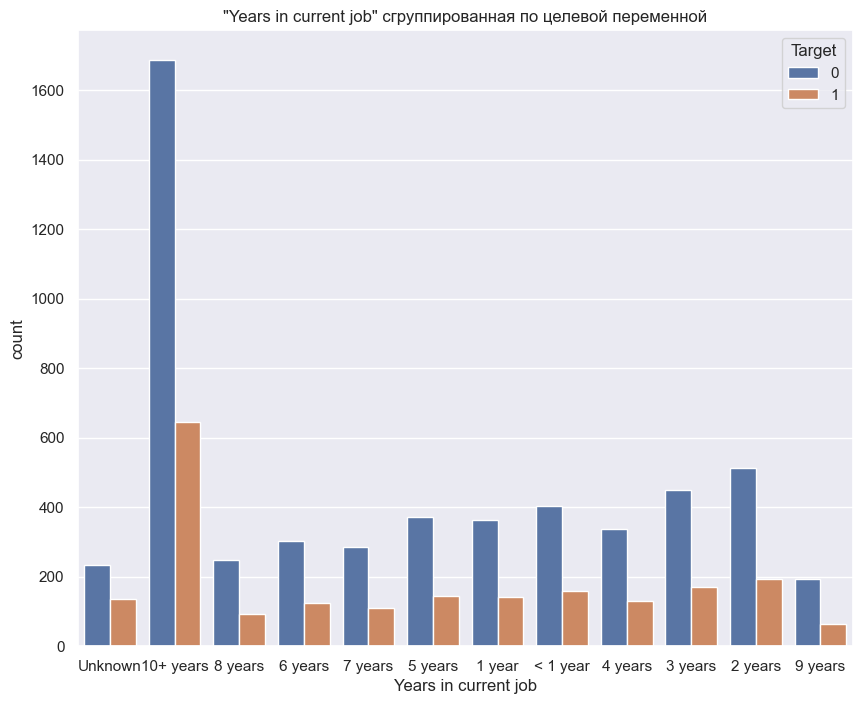

In [86]:
grouped_by_target(df_train, 'Years in current job', 'Credit Default')

In [87]:
df_train['Is_Years_in_current_job'] = df_train['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

In [88]:
df_test['Is_Years_in_current_job'] = df_test['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

**Home Ownership**

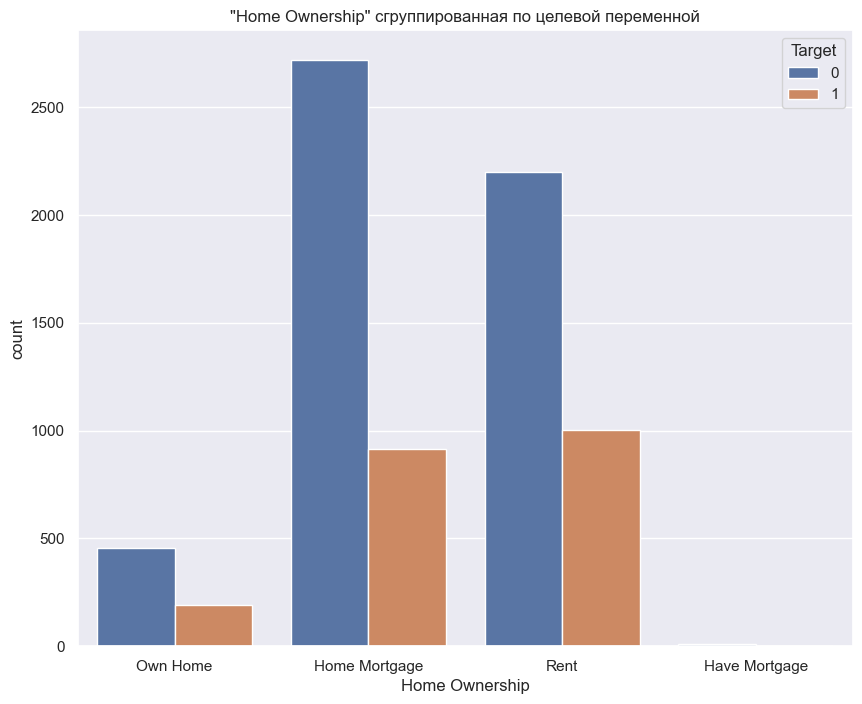

In [89]:
grouped_by_target(df_train, 'Home Ownership', 'Credit Default')

In [90]:
combine_into_category_table(df_train, 'Home Ownership', 'Credit Default', 'ID')

,Own Home,Home Mortgage,Rent,Have Mortgage
Own Home,,False,True,True
Home Mortgage,False,,False,True
Rent,True,False,,True
Have Mortgage,True,True,True,


Значения "Own Home", "Rent" и "Have Mortgage" можно собрать в одно значение

In [91]:
df_train['Is_Home_Ownership'] = df_train['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

In [92]:
df_test['Is_Home_Ownership'] = df_test['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

**Purpose**

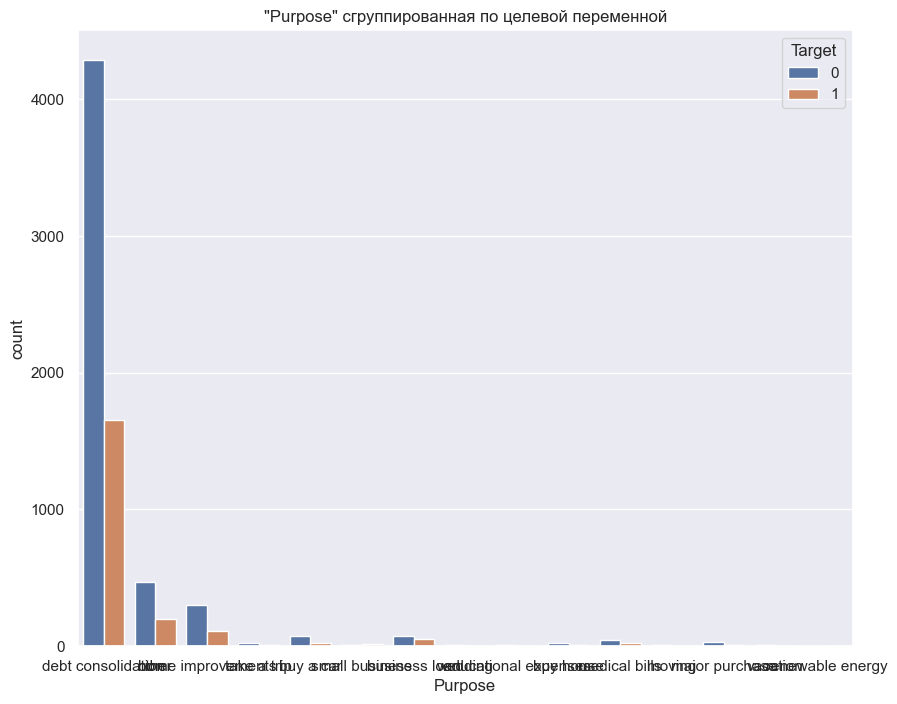

In [95]:
grouped_by_target(df_train, 'Purpose', 'Credit Default')

In [96]:
combine_into_category_table(df_train, 'Purpose', 'Credit Default', 'ID')

,debt consolidation,other,home improvements,take a trip,buy a car,small business,business loan,wedding,educational expenses,buy house,medical bills,moving,major purchase,vacation,renewable energy
debt consolidation,,True,True,True,True,False,False,True,True,True,True,True,True,True,False
other,True,,True,True,True,False,False,True,True,True,True,True,True,True,False
home improvements,True,True,,True,True,False,False,True,True,True,True,True,True,True,False
take a trip,True,True,True,,True,False,True,True,True,True,True,True,True,True,False
buy a car,True,True,True,True,,False,False,True,True,True,True,True,True,True,False
small business,False,False,False,False,False,,True,True,False,False,False,False,False,True,False
business loan,False,False,False,True,False,True,,True,False,True,True,True,False,True,False
wedding,True,True,True,True,True,True,True,,True,True,True,True,True,True,False
educational expenses,True,True,True,True,True,False,False,True,,True,True,True,True,True,False
buy house,True,True,True,True,True,False,True,True,True,,True,True,True,True,False


Все значения показателя, кроме "small business", "business loan" и "renewable energy" можно собрать в одно значение.

In [97]:
df_train['Is_Purpose'] = df_train['Purpose'].map({'debt consolidation':'other',
                                                  'other':'other',
                                                  'home improvements':'other',
                                                  'take a trip':'other',
                                                  'buy a car':'other',
                                                  'small business':'small business',
                                                  'business loan':'business loan',
                                                  'wedding':'other',
                                                  'educational expenses':'other',
                                                  'buy house':'other',
                                                  'medical bills':'other',
                                                  'moving':'other',
                                                  'major purchase':'other',
                                                  'vacation':'other',
                                                  'renewable energy':'renewable energy'})

In [98]:
df_test['Is_Purpose'] = df_test['Purpose'].map({'debt consolidation':'other',
                                                'other':'other',
                                                'home improvements':'other',
                                                'take a trip':'other',
                                                'buy a car':'other',
                                                'small business':'small business',
                                                'business loan':'business loan',
                                                'wedding':'other',
                                                'educational expenses':'other',
                                                'buy house':'other',
                                                'medical bills':'other',
                                                'moving':'other',
                                                'major purchase':'other',
                                                'vacation':'other',
                                                'renewable energy':'renewable energy'})

In [99]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Is_Purpose'], prefix='Is_Purpose')], axis=1)

In [100]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Is_Purpose'], prefix='Is_Purpose')], axis=1)

# 5. Анализ данных

### 5.1 Выделение целевой переменной и групп признаков

In [101]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [102]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [103]:
NEW_FEATURE_NAMES

Index(['ID', 'Is_Term', 'Is_Years_in_current_job', 'Is_Home_Ownership',
       'Is_Purpose', 'Is_Purpose_business loan', 'Is_Purpose_other',
       'Is_Purpose_renewable energy', 'Is_Purpose_small business'],
      dtype='object')

### 5.2 Анализ целевой переменной

**Обзор распределения**

In [104]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Наблюдается диспропорция между значениями "1" и "0"

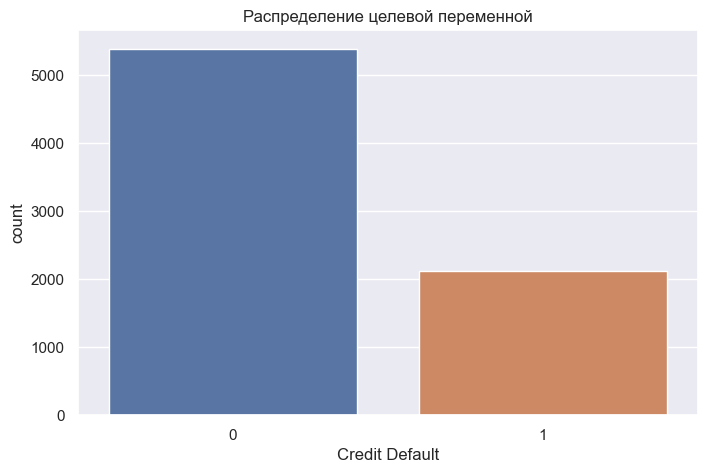

In [105]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

**Корреляция с базовыми признаками**

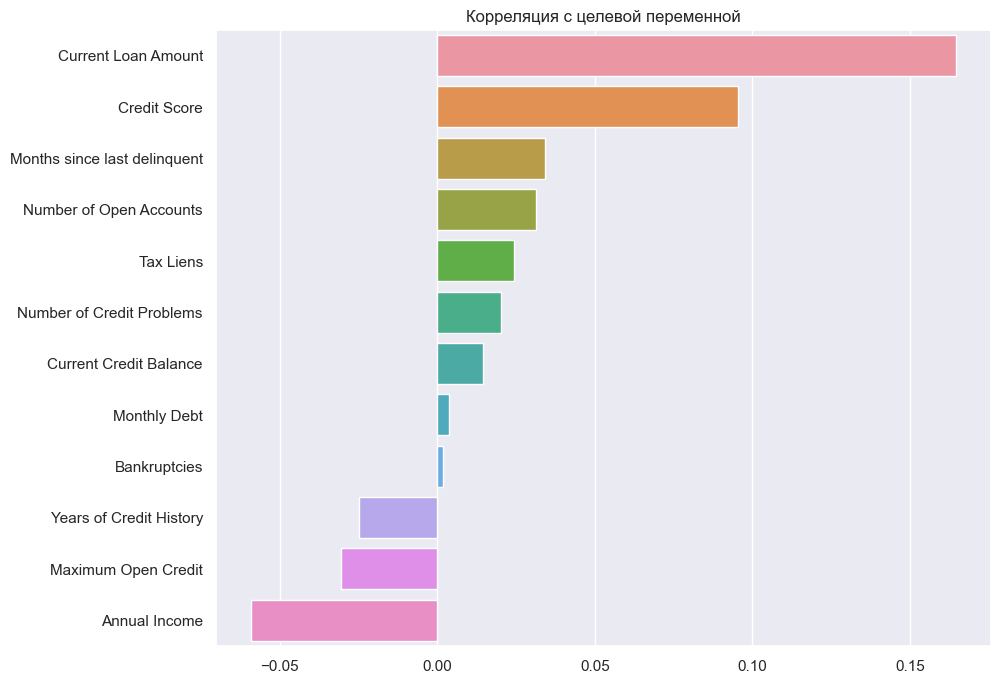

In [106]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

Следующие показатели возможно имеет смысл сделать категориальными (у них мало классов): **Tax Liens**, **Number of Credit Problems**, **Bankruptcies**.

__Оценка признака «Annual Income» в разрезе целевой переменной__

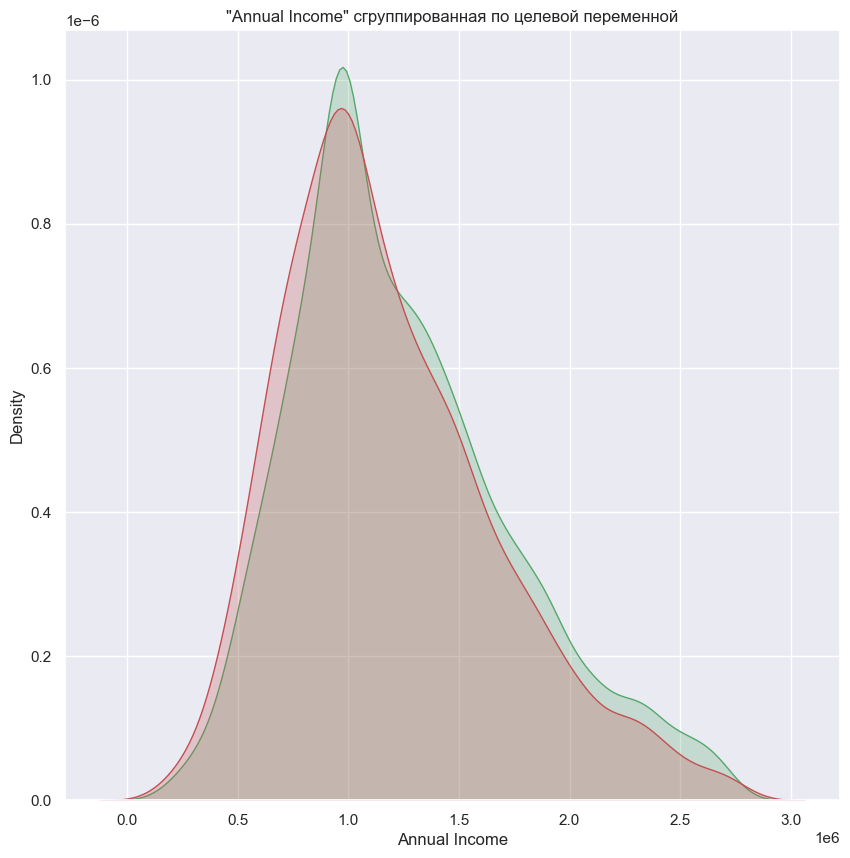

Показатель «Annual Income» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


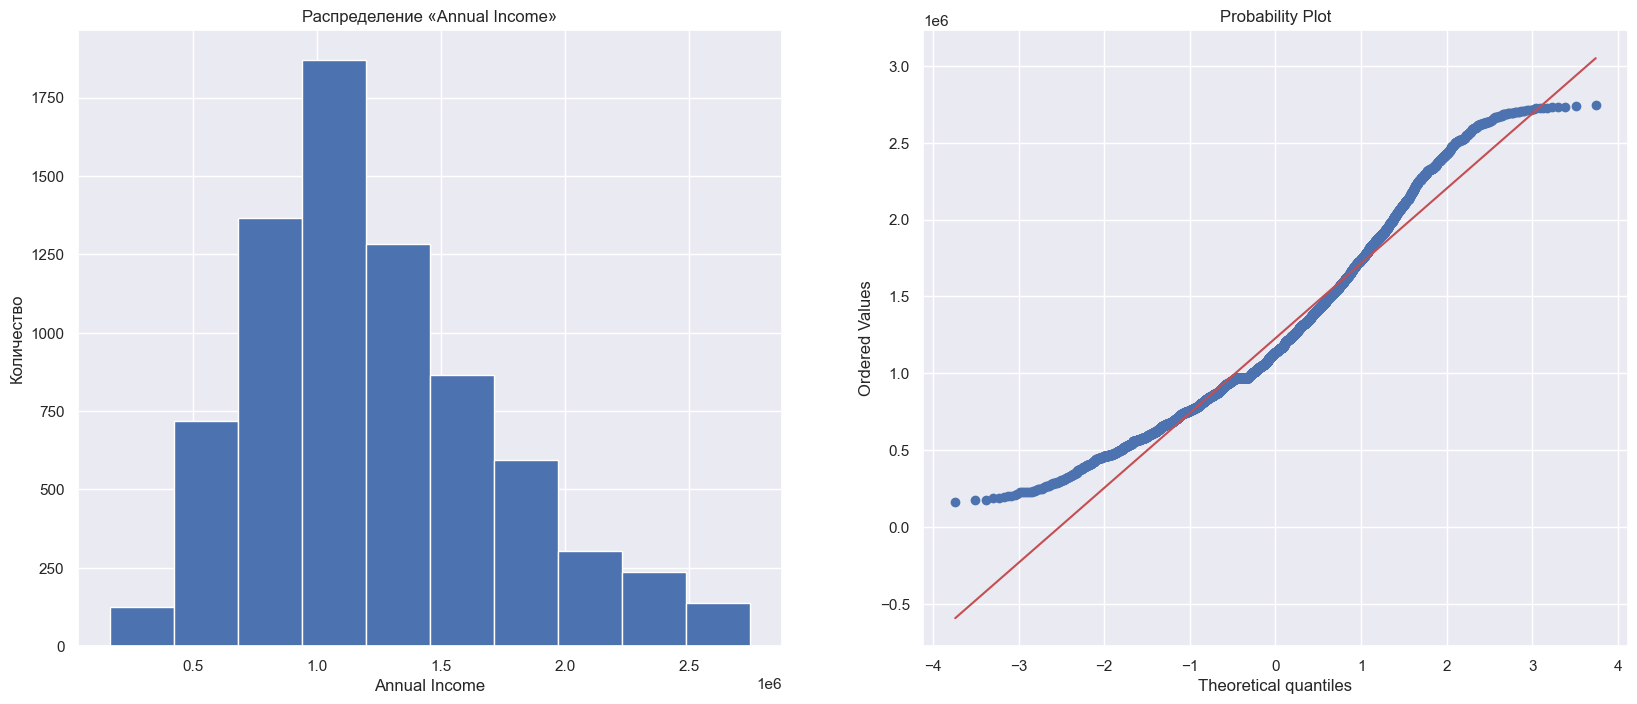

По показателю «Annual Income» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


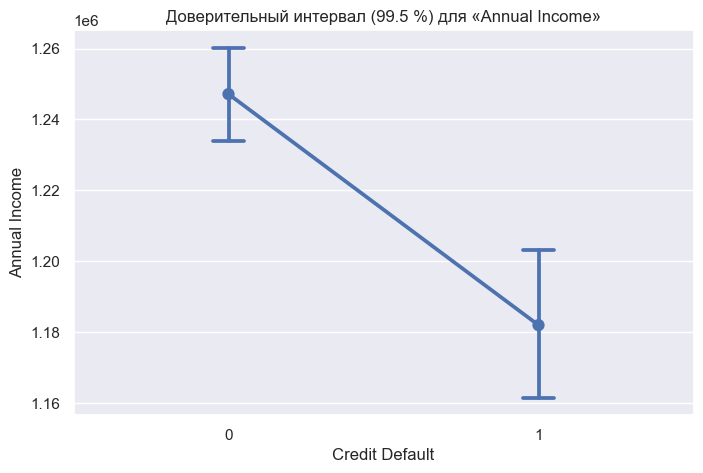

__Оценка признака «Tax Liens» в разрезе целевой переменной__

Показатель «Tax Liens» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


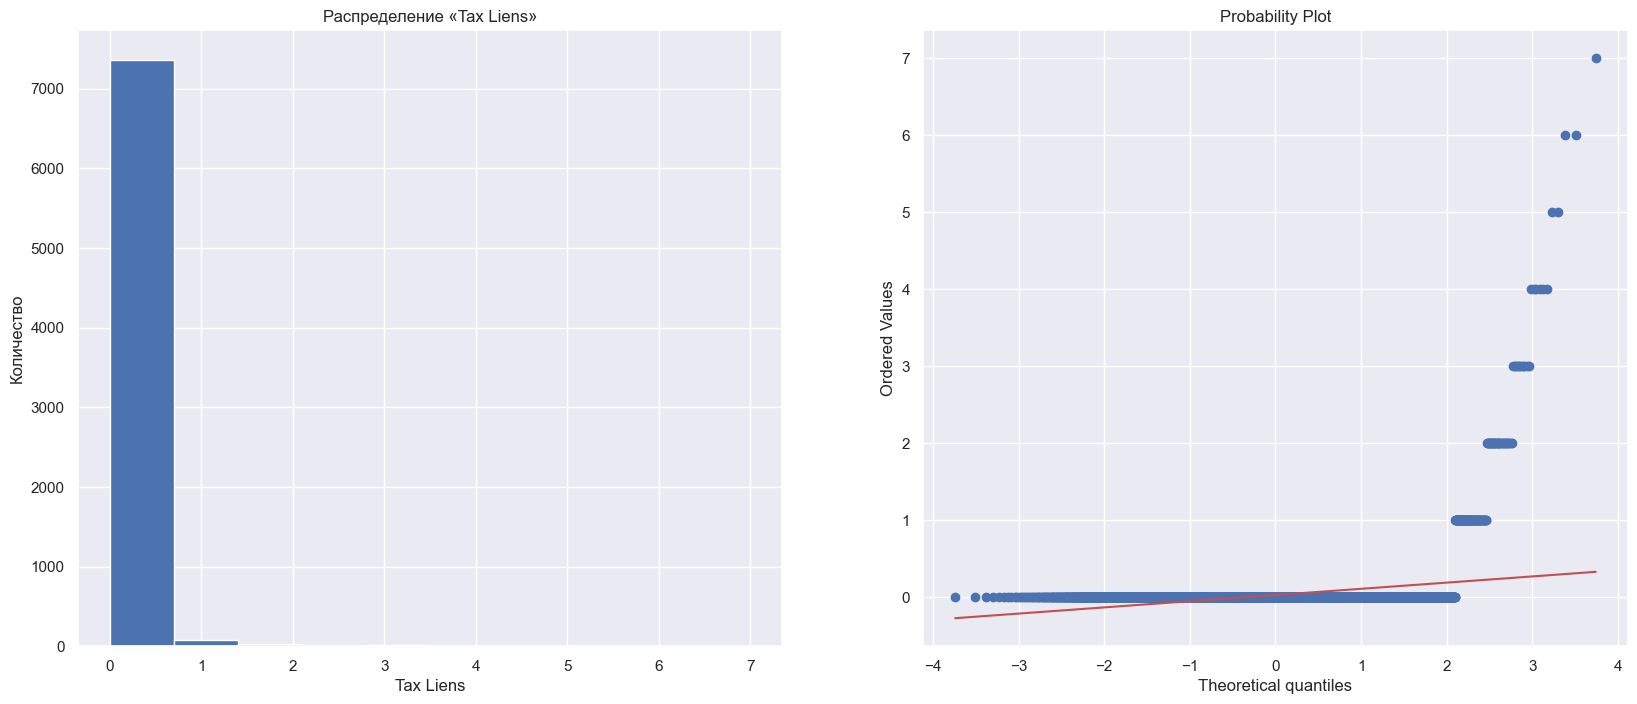

По показателю «Tax Liens» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


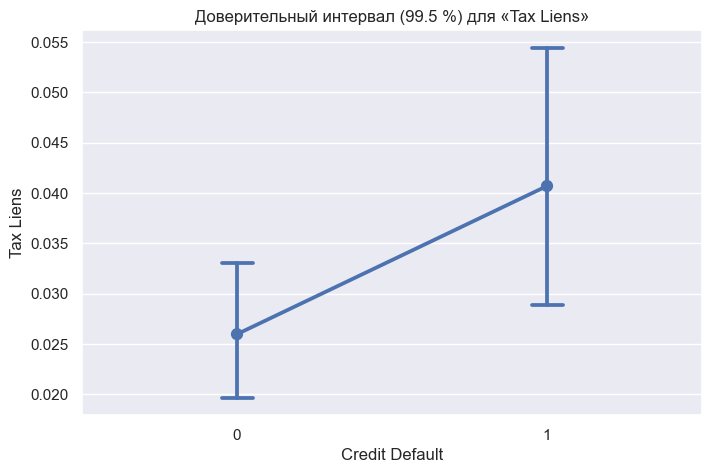

__Оценка признака «Number of Open Accounts» в разрезе целевой переменной__

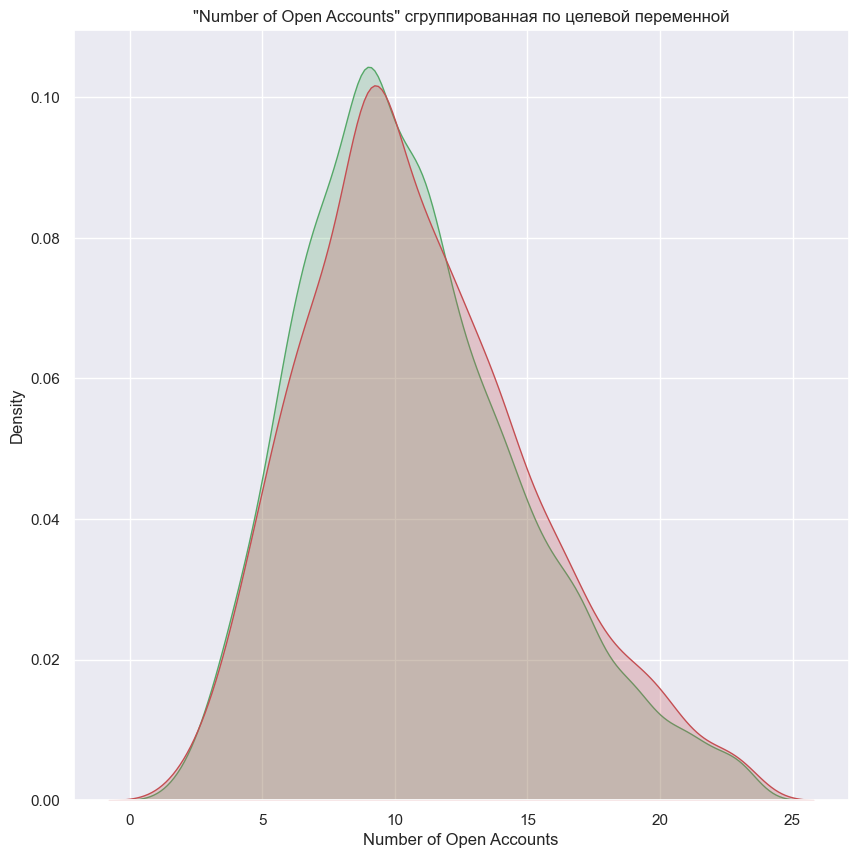

Показатель «Number of Open Accounts» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


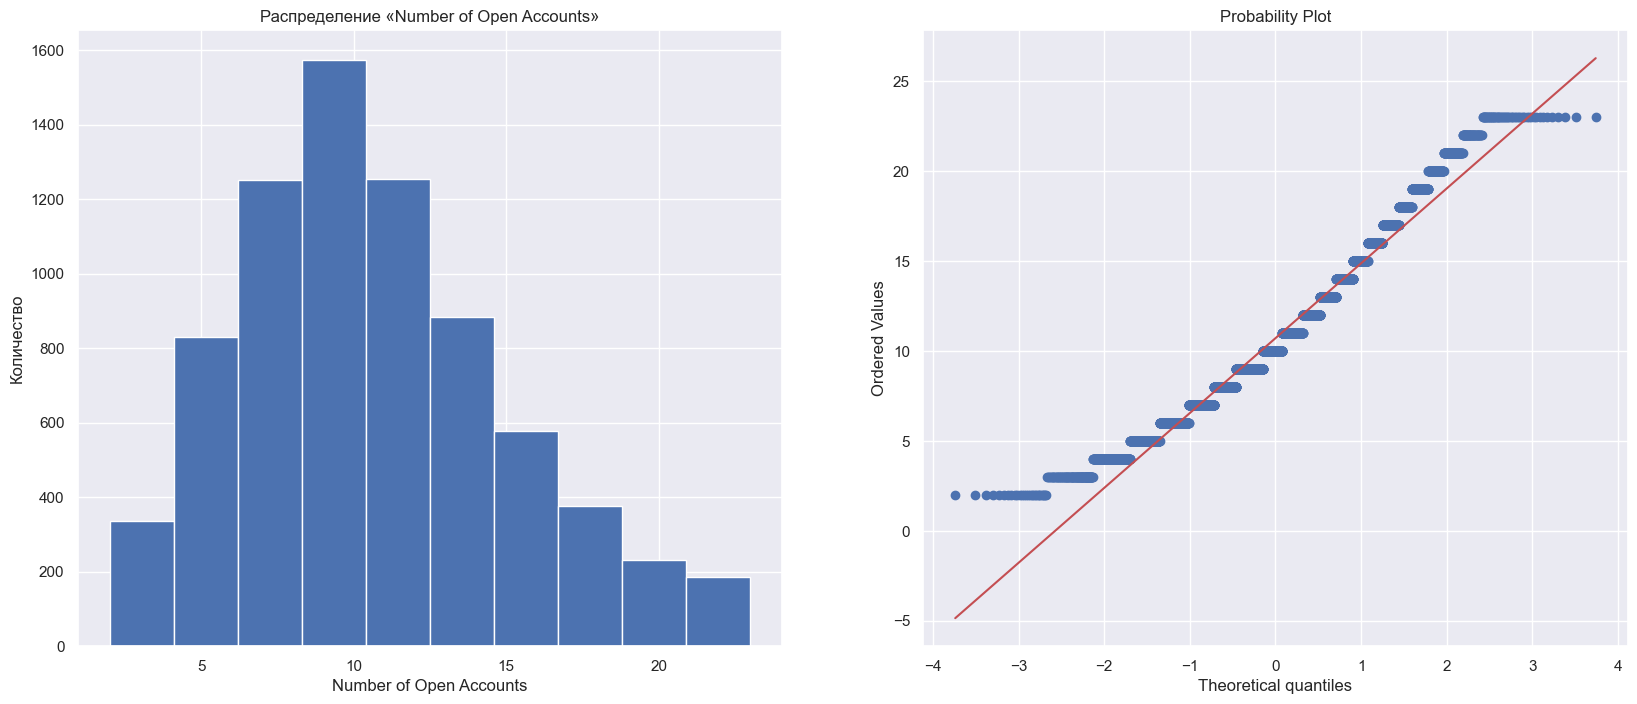

По показателю «Number of Open Accounts» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


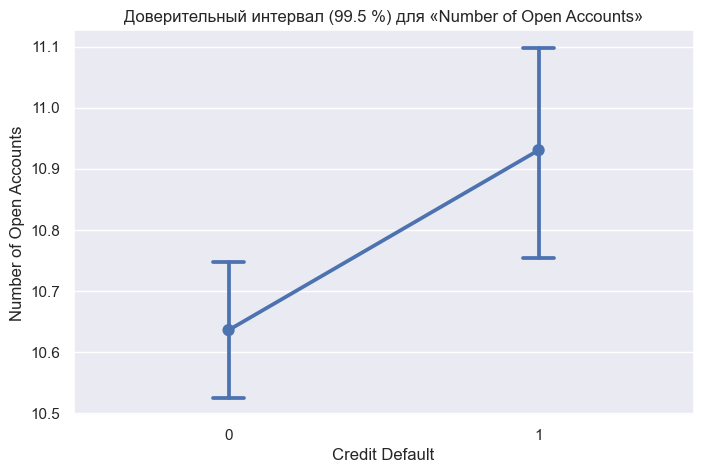

__Оценка признака «Years of Credit History» в разрезе целевой переменной__

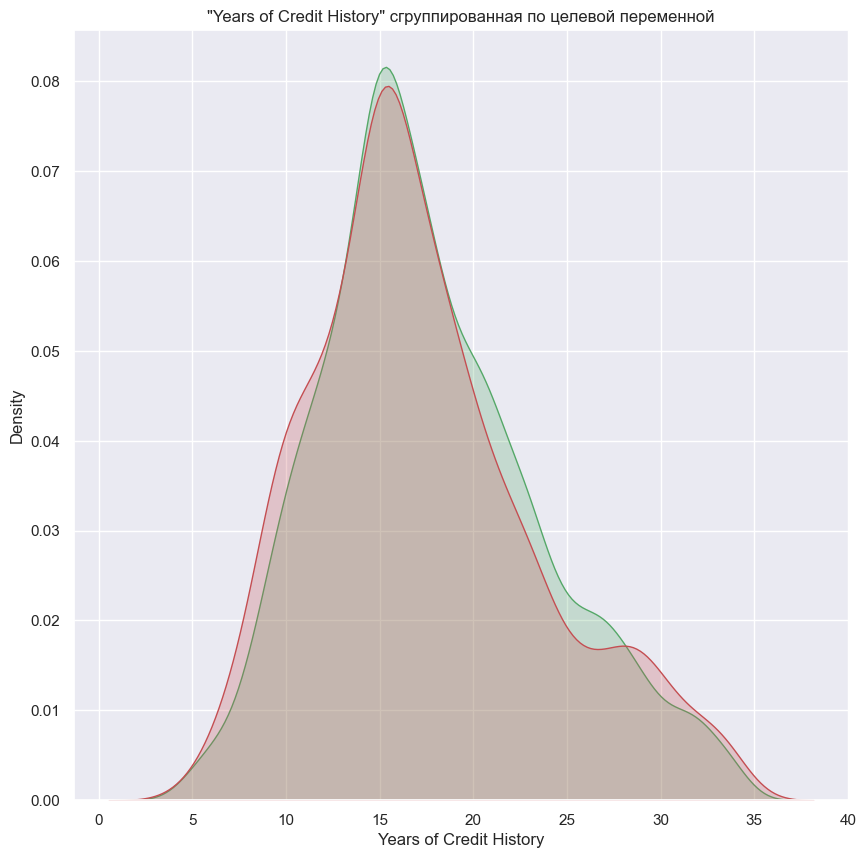

Показатель «Years of Credit History» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


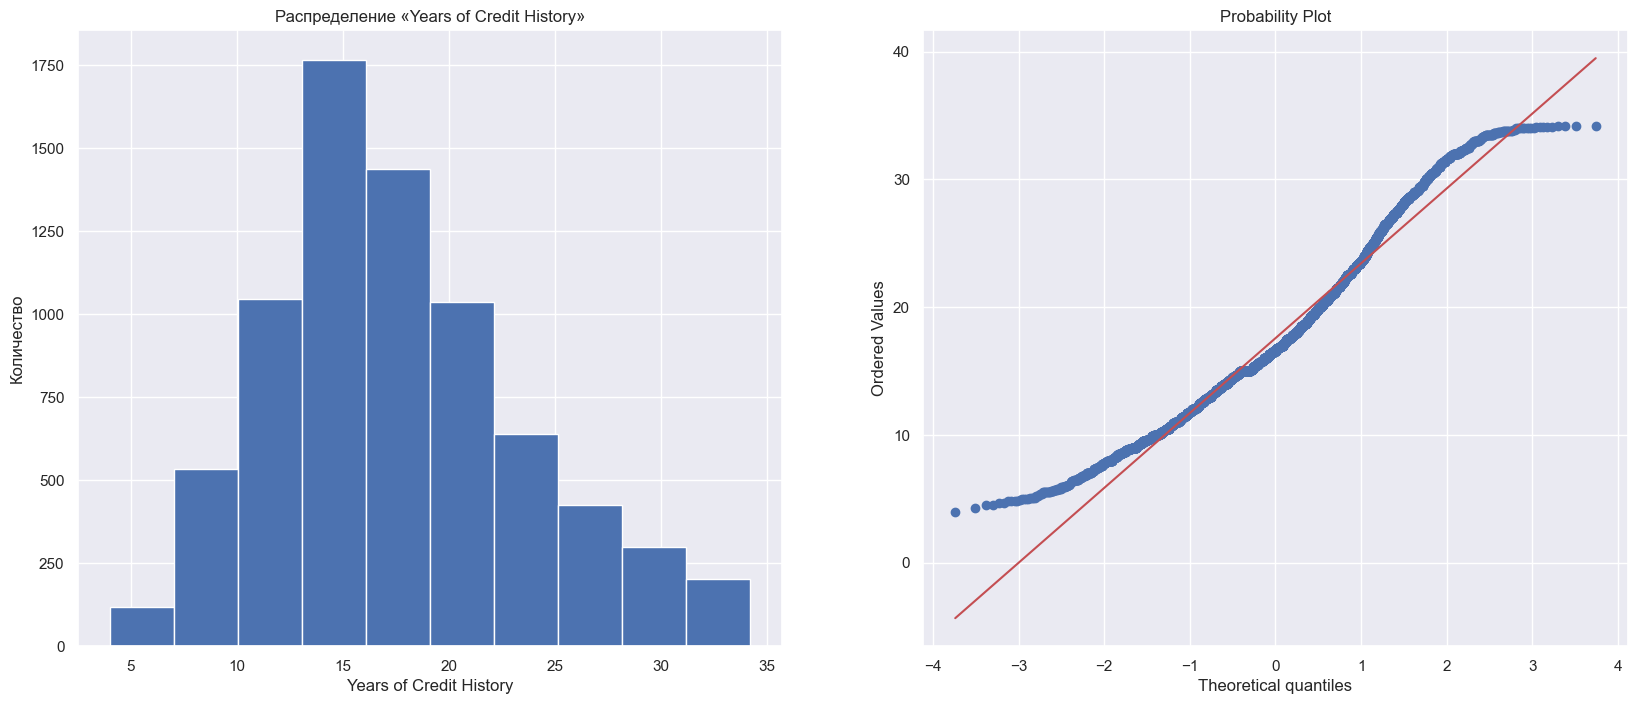

По показателю «Years of Credit History» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


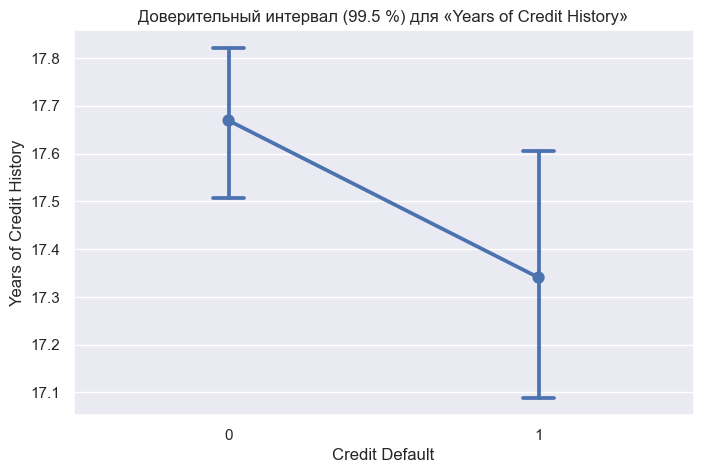

__Оценка признака «Maximum Open Credit» в разрезе целевой переменной__

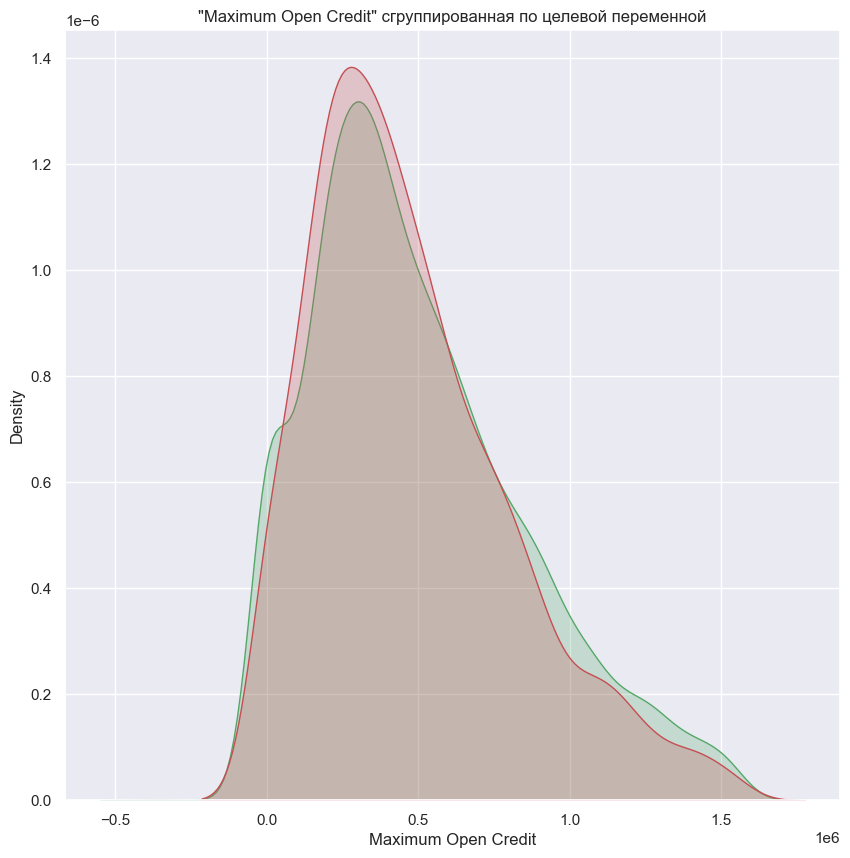

Показатель «Maximum Open Credit» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


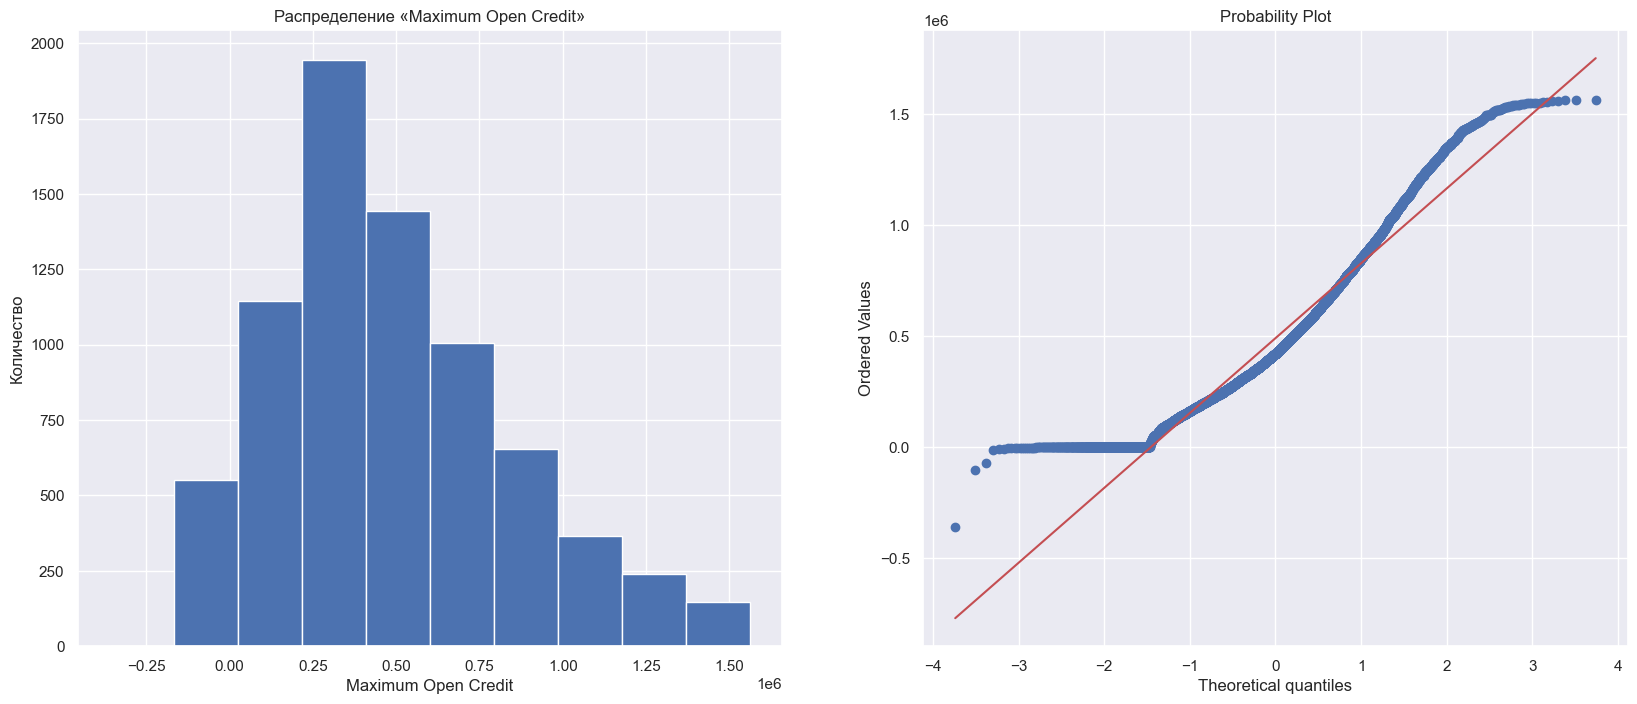

По показателю «Maximum Open Credit» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


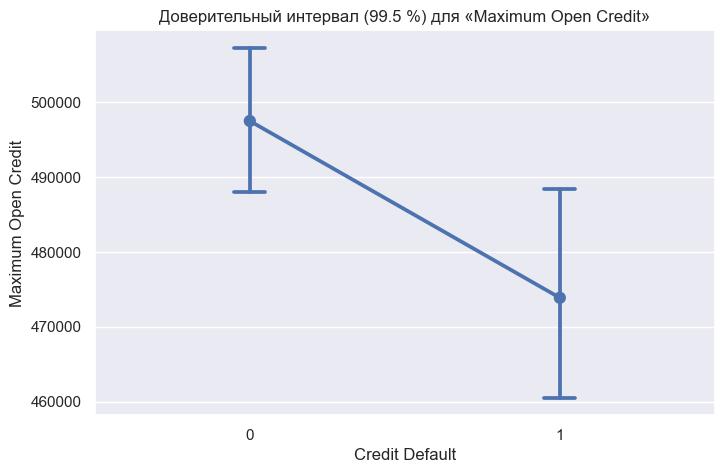

__Оценка признака «Number of Credit Problems» в разрезе целевой переменной__

Показатель «Number of Credit Problems» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


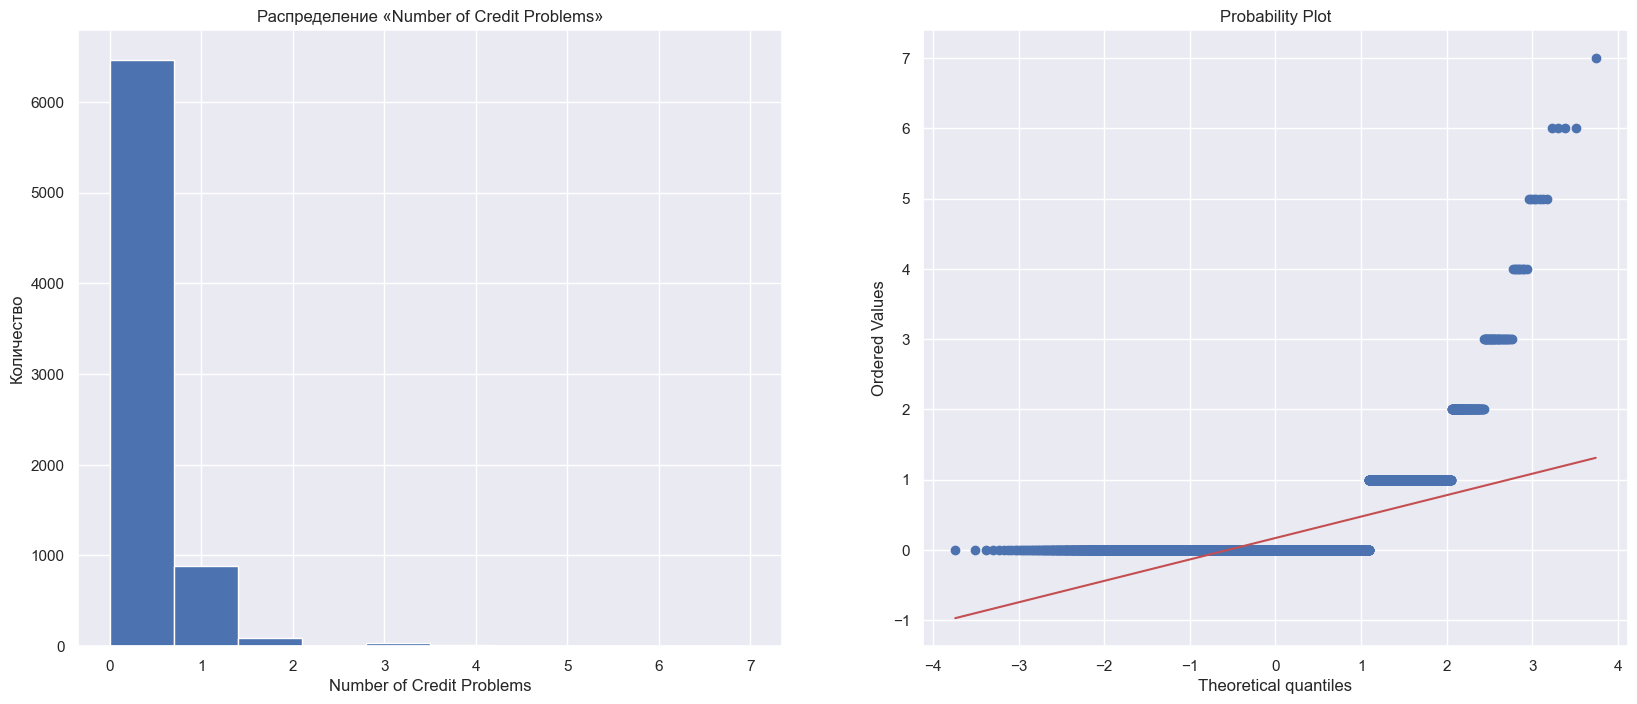

По показателю «Number of Credit Problems» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


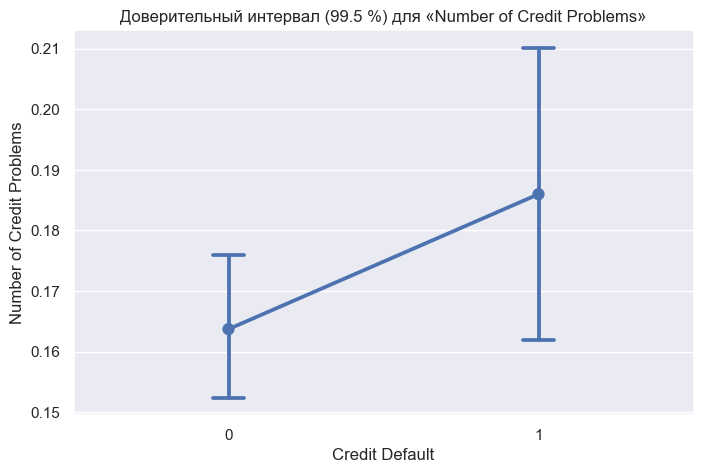

__Оценка признака «Months since last delinquent» в разрезе целевой переменной__

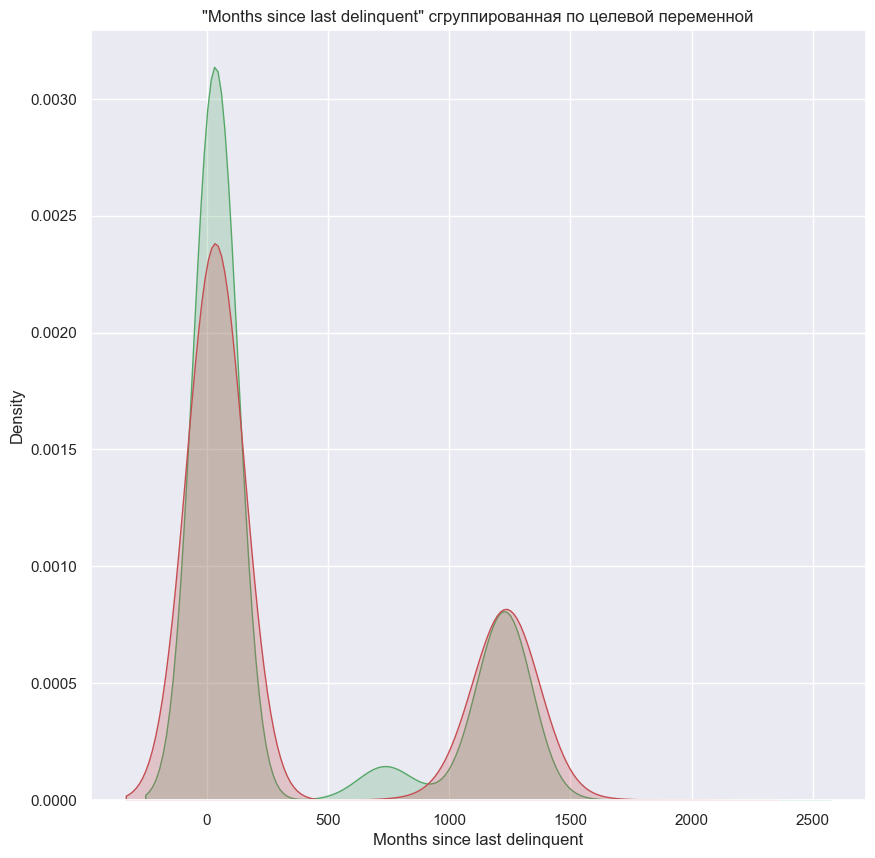

Показатель «Months since last delinquent» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


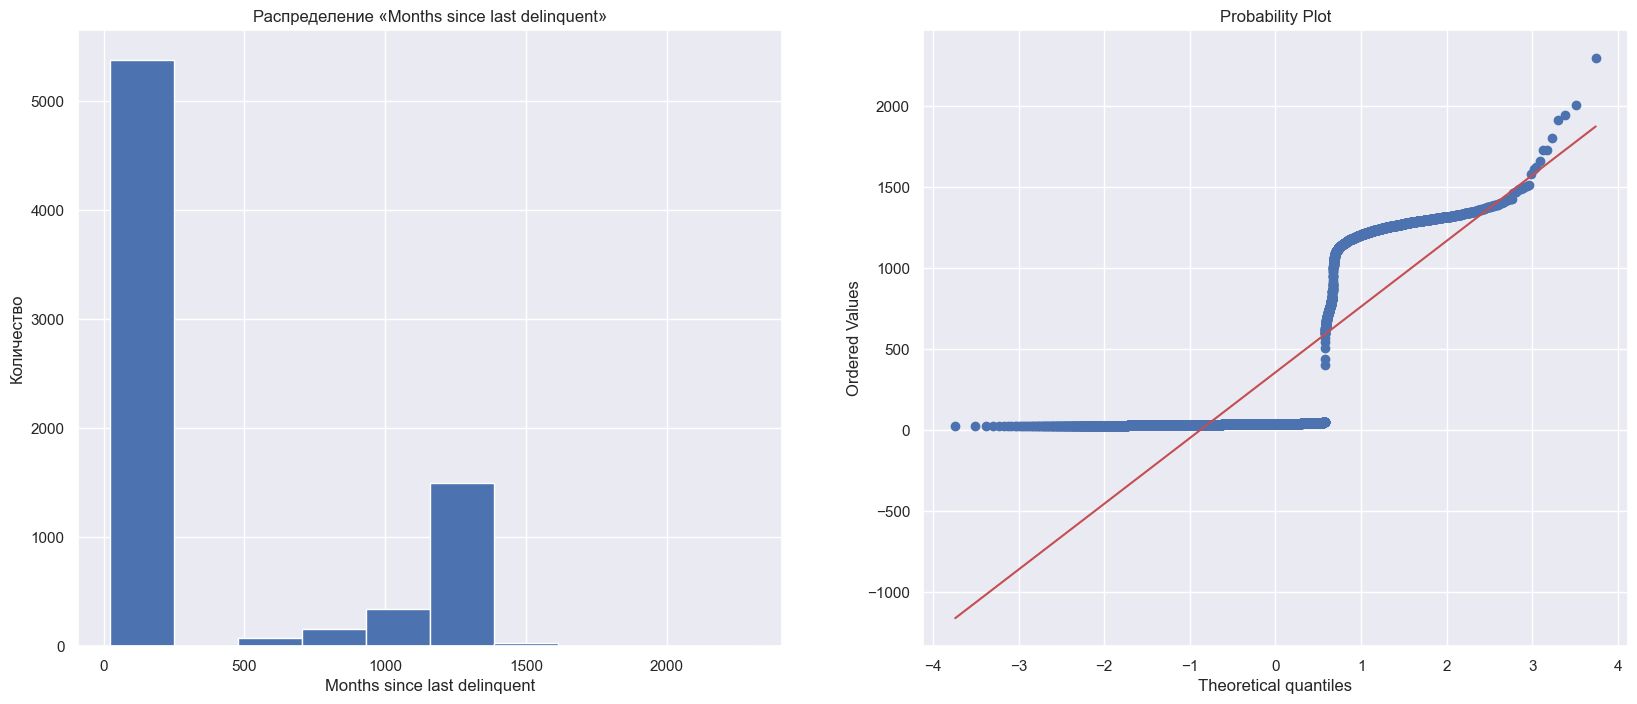

По показателю «Months since last delinquent» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


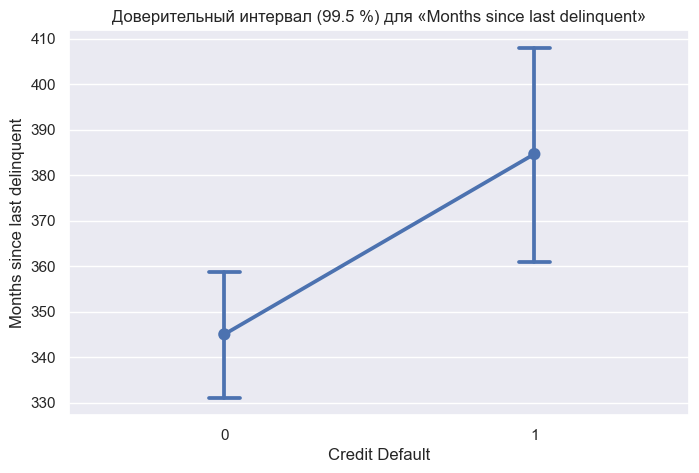

__Оценка признака «Bankruptcies» в разрезе целевой переменной__

Показатель «Bankruptcies» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


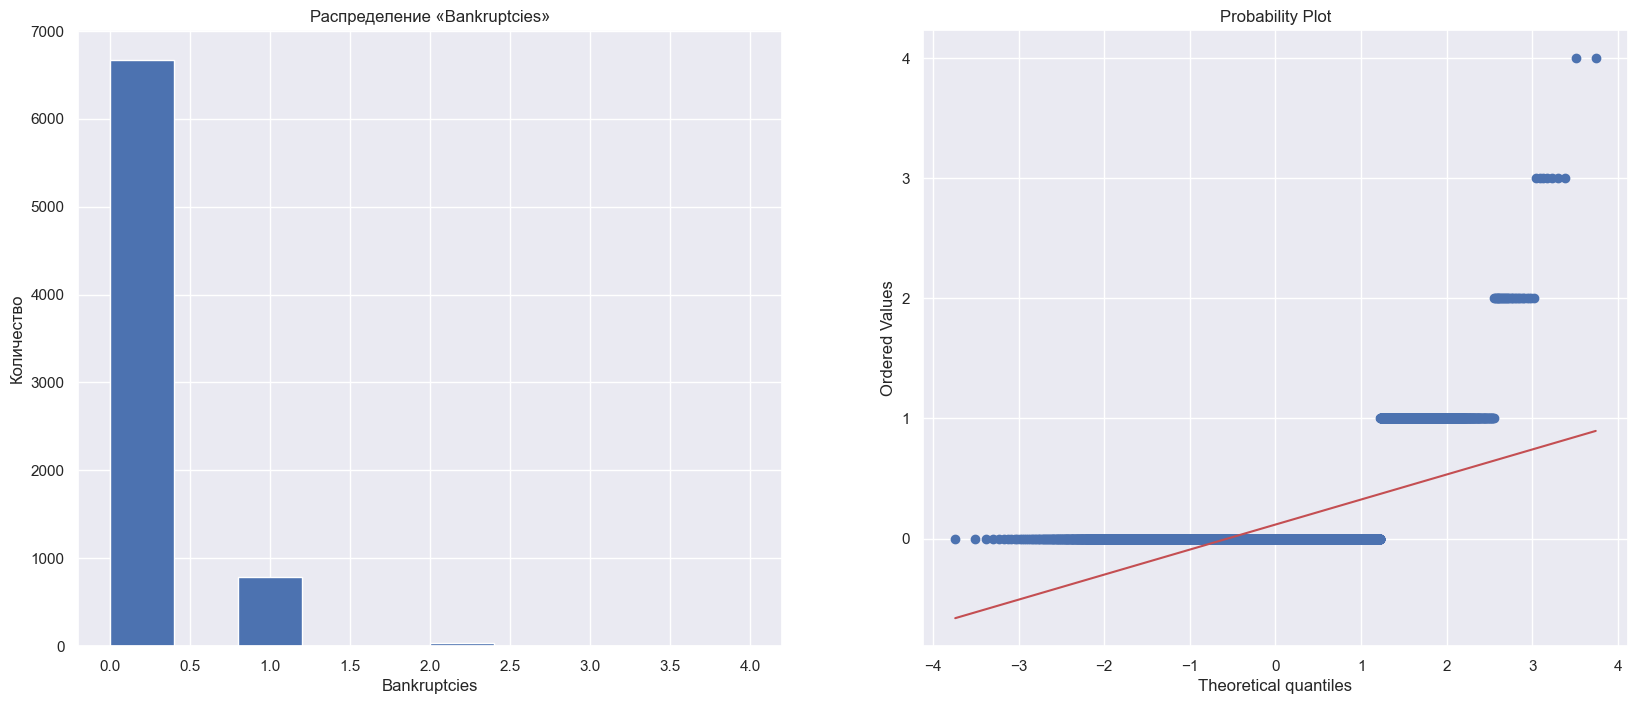

По показателю «Bankruptcies» нельзя построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


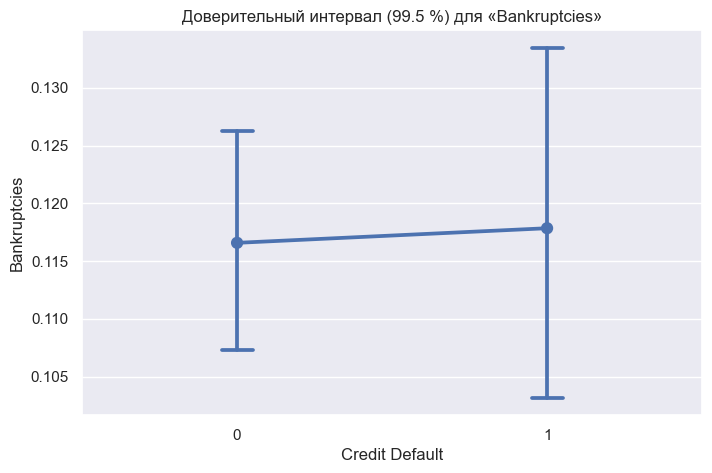

__Оценка признака «Current Loan Amount» в разрезе целевой переменной__

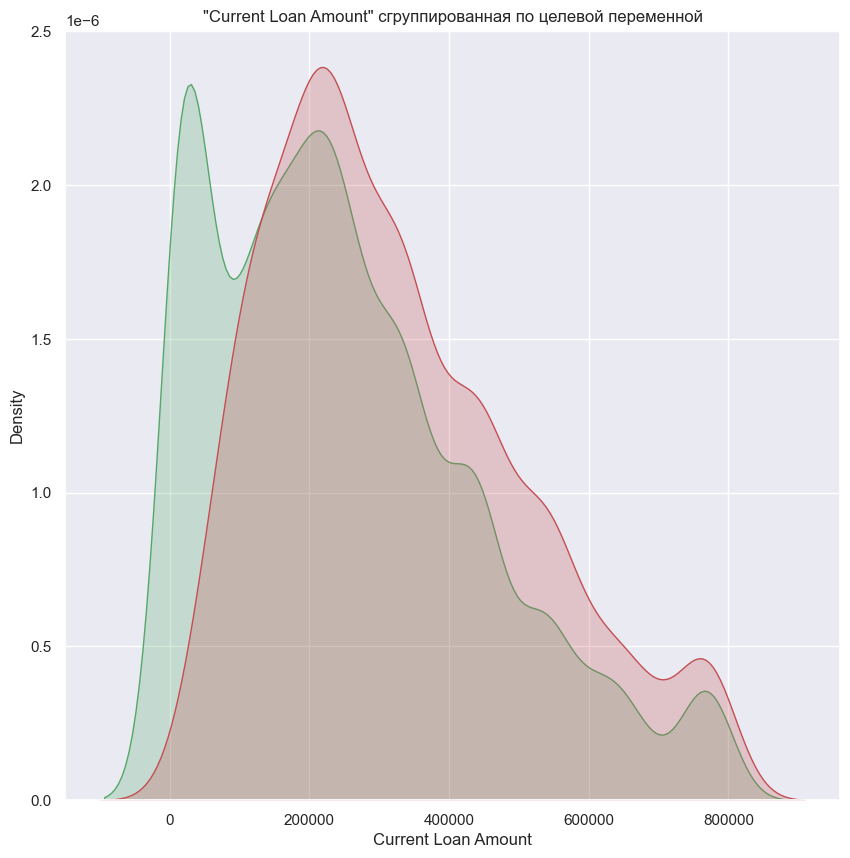

Показатель «Current Loan Amount» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


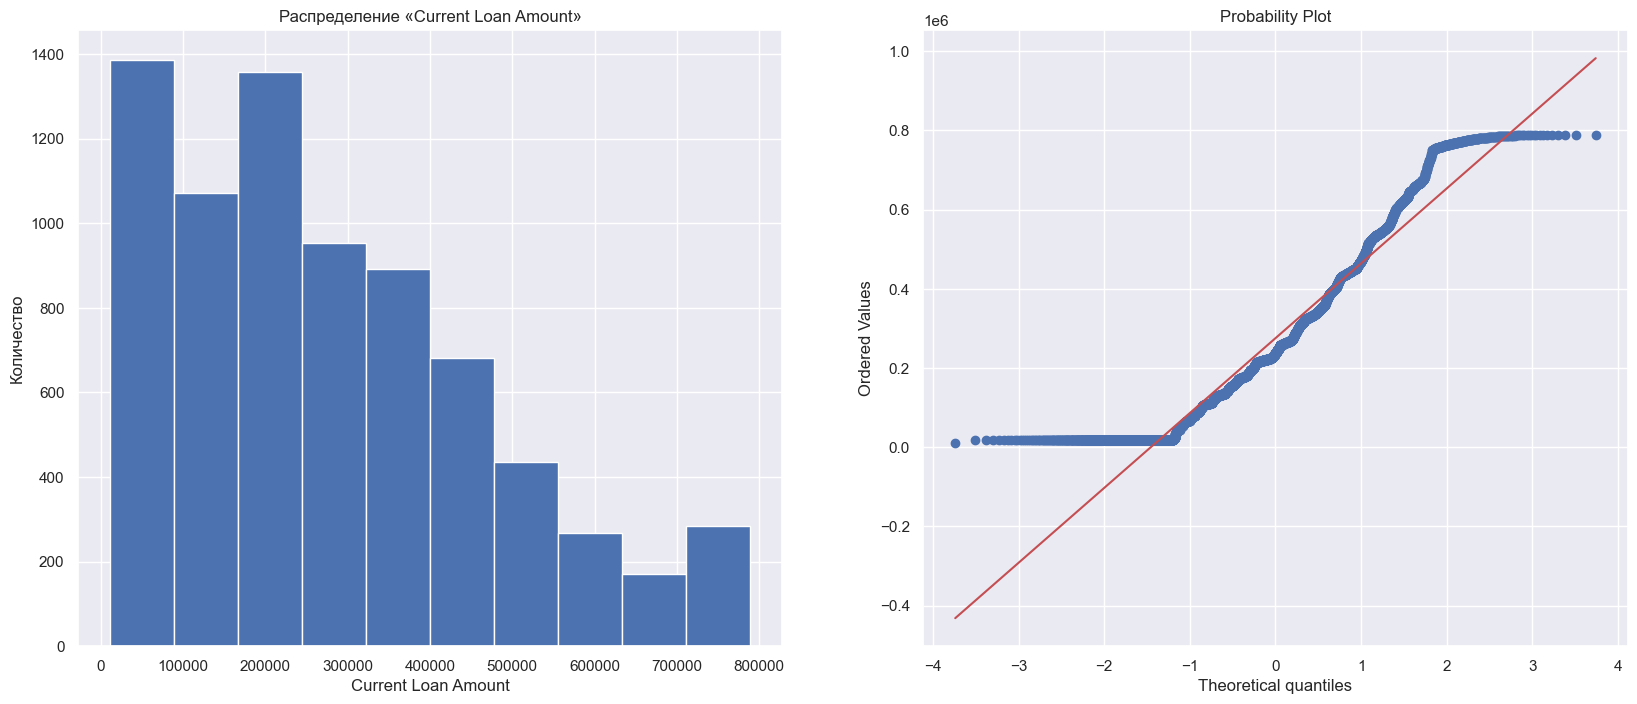

По показателю «Current Loan Amount» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


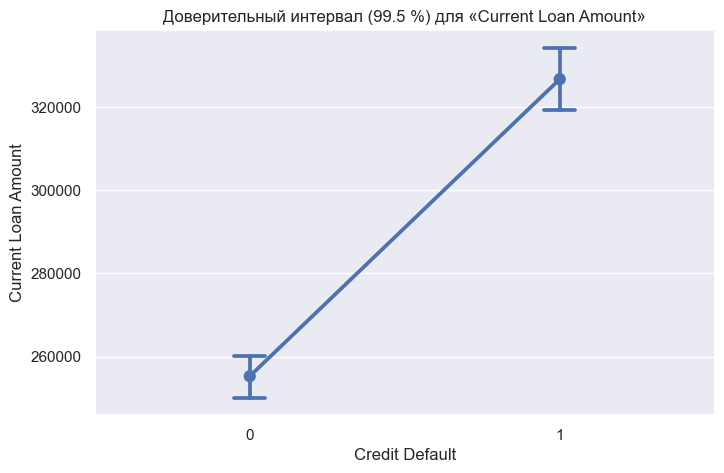

__Оценка признака «Current Credit Balance» в разрезе целевой переменной__

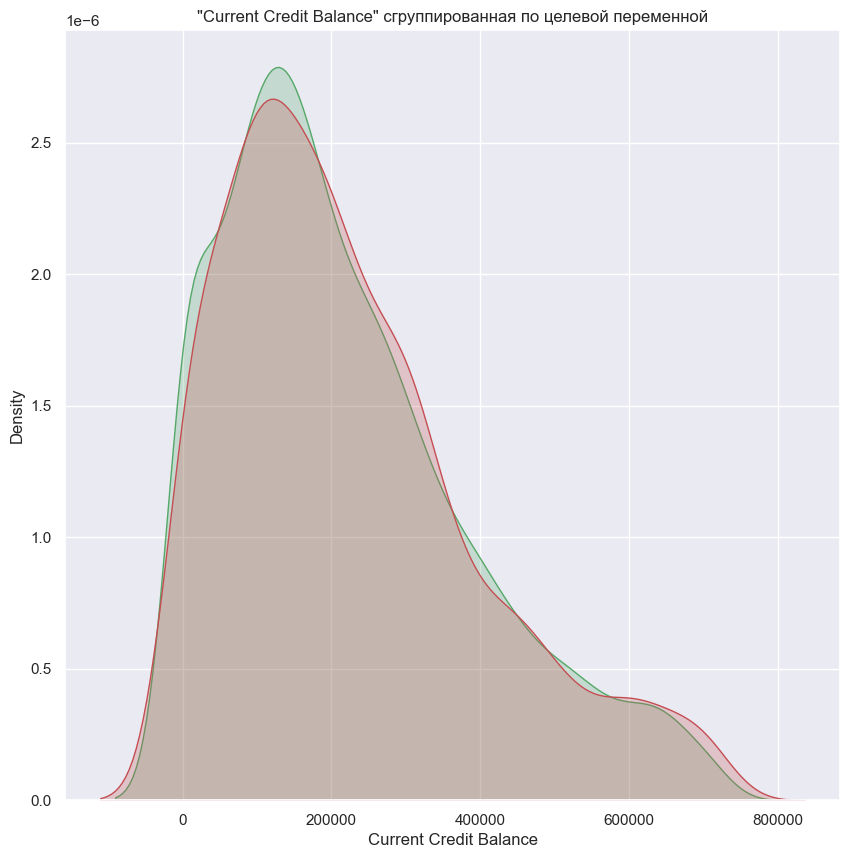

Показатель «Current Credit Balance» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


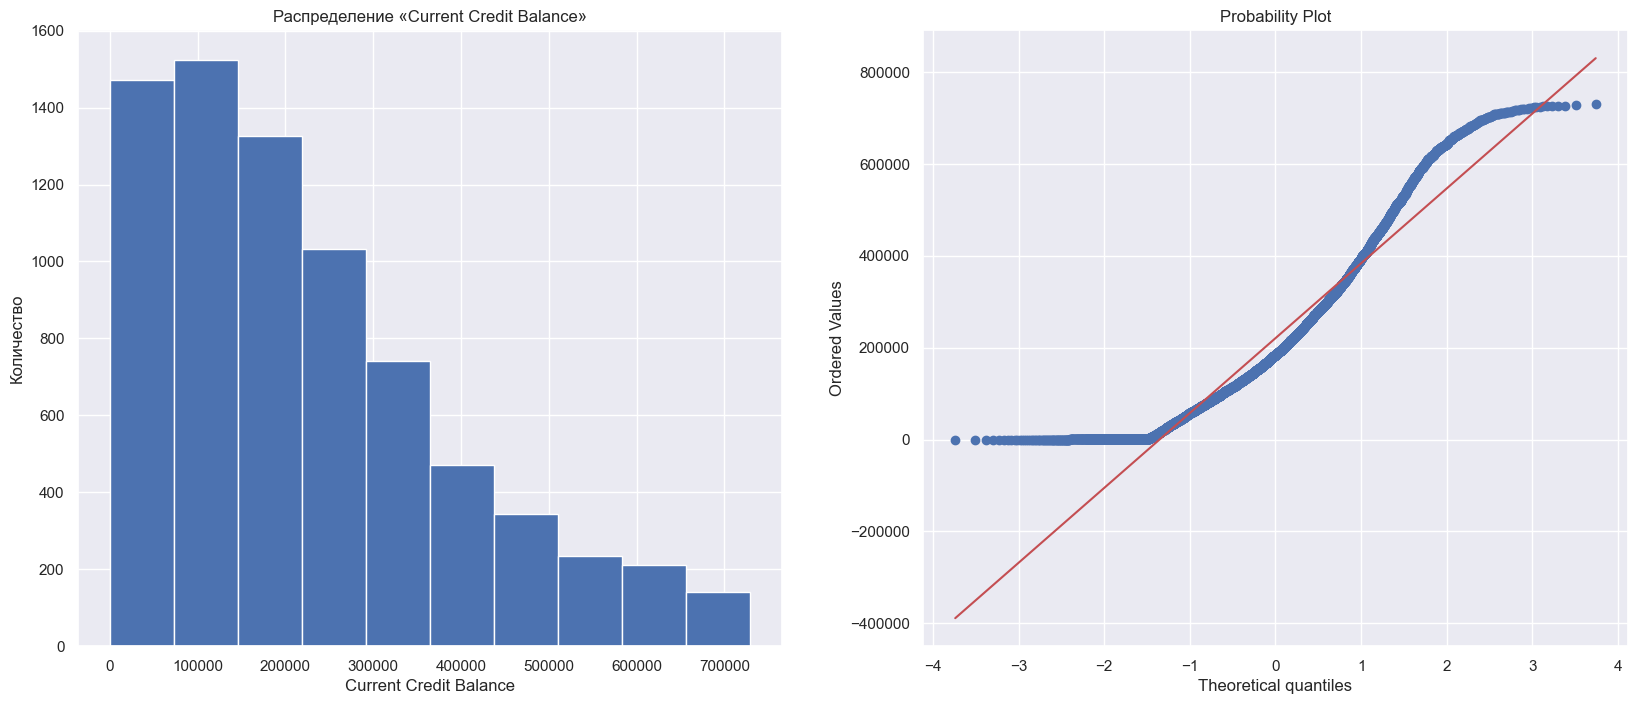

По показателю «Current Credit Balance» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


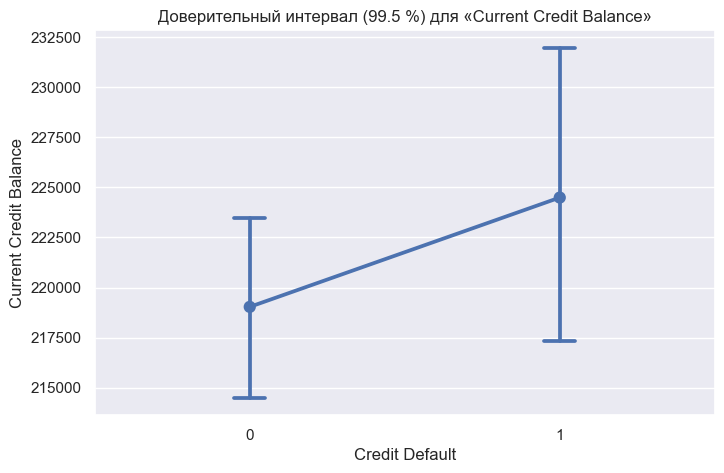

__Оценка признака «Monthly Debt» в разрезе целевой переменной__

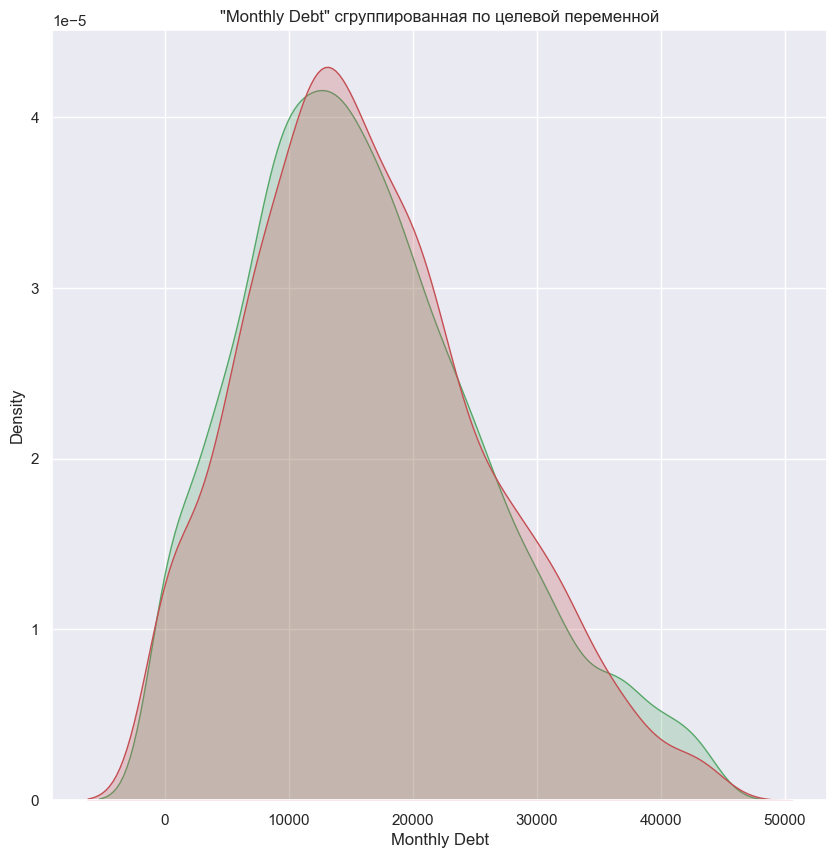

Показатель «Monthly Debt» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


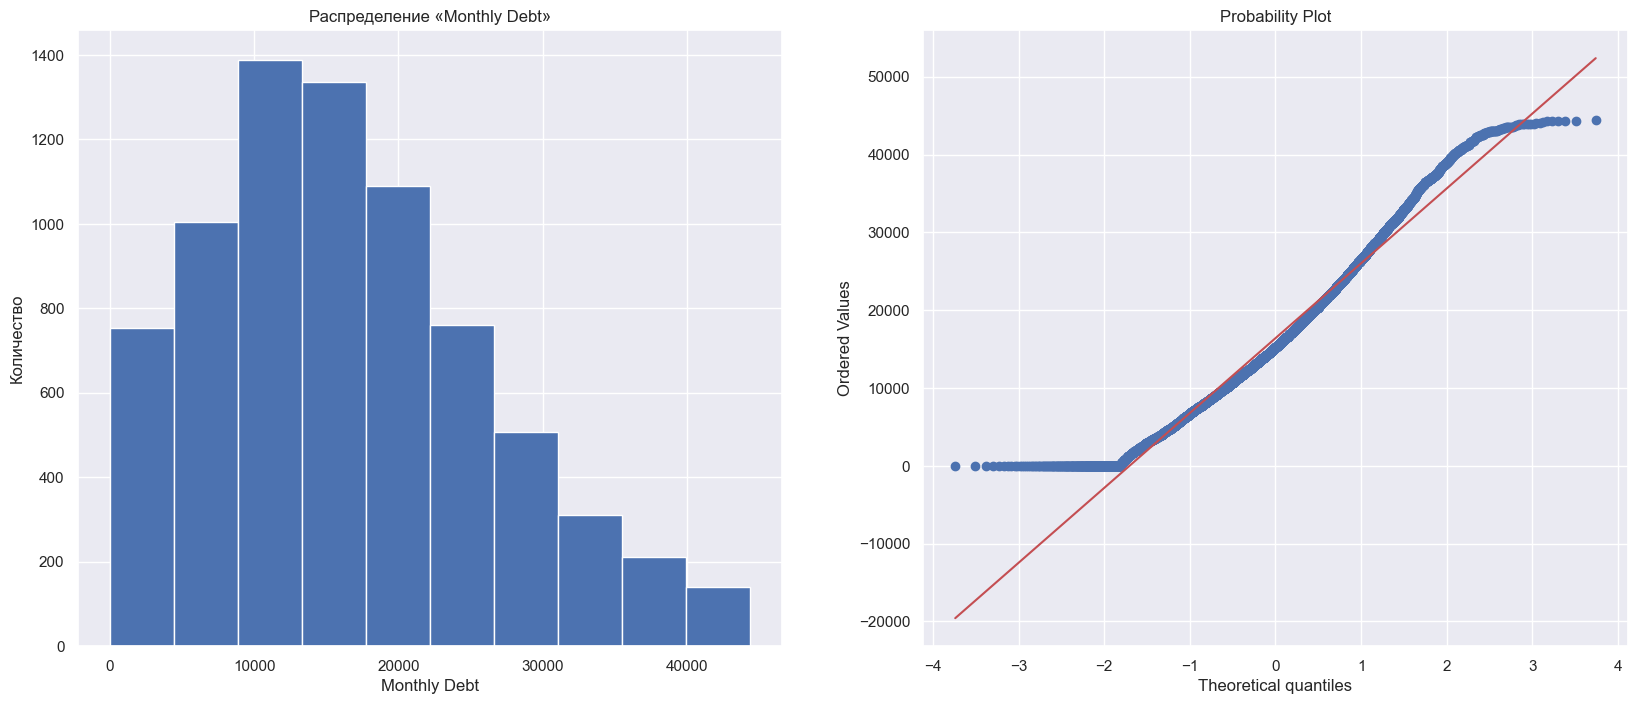

По показателю «Monthly Debt» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


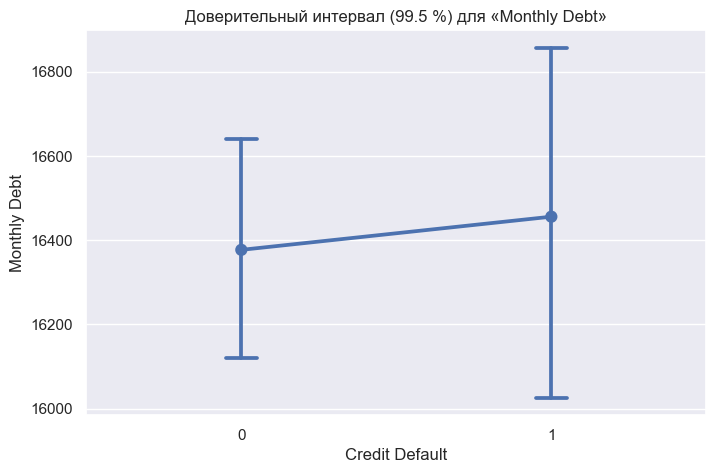

__Оценка признака «Credit Score» в разрезе целевой переменной__

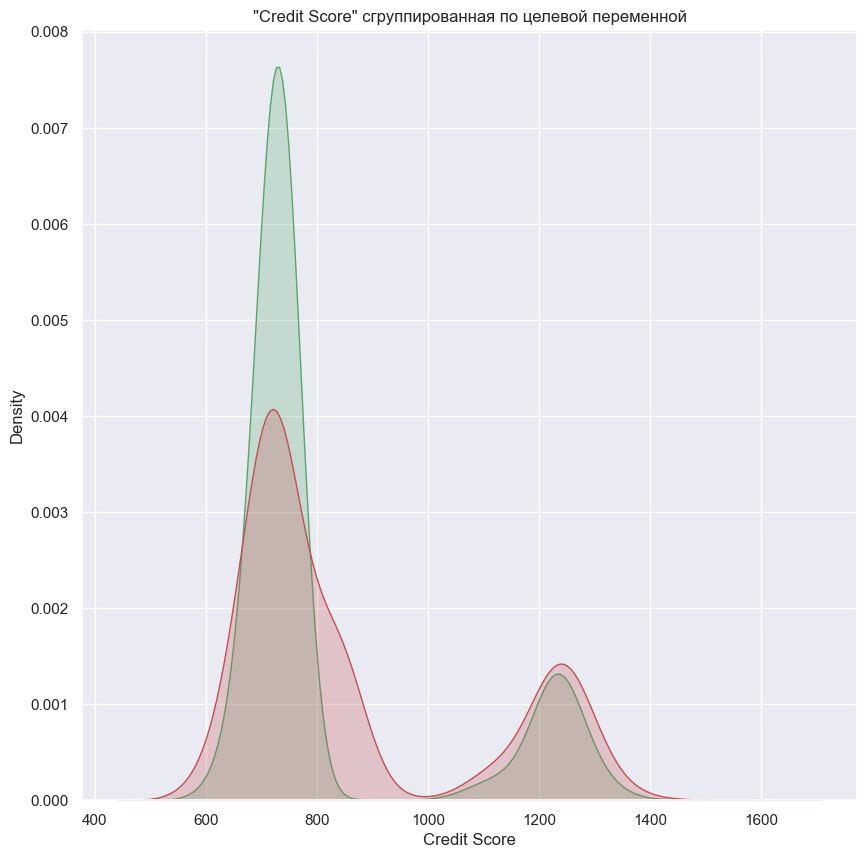

Показатель «Credit Score» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


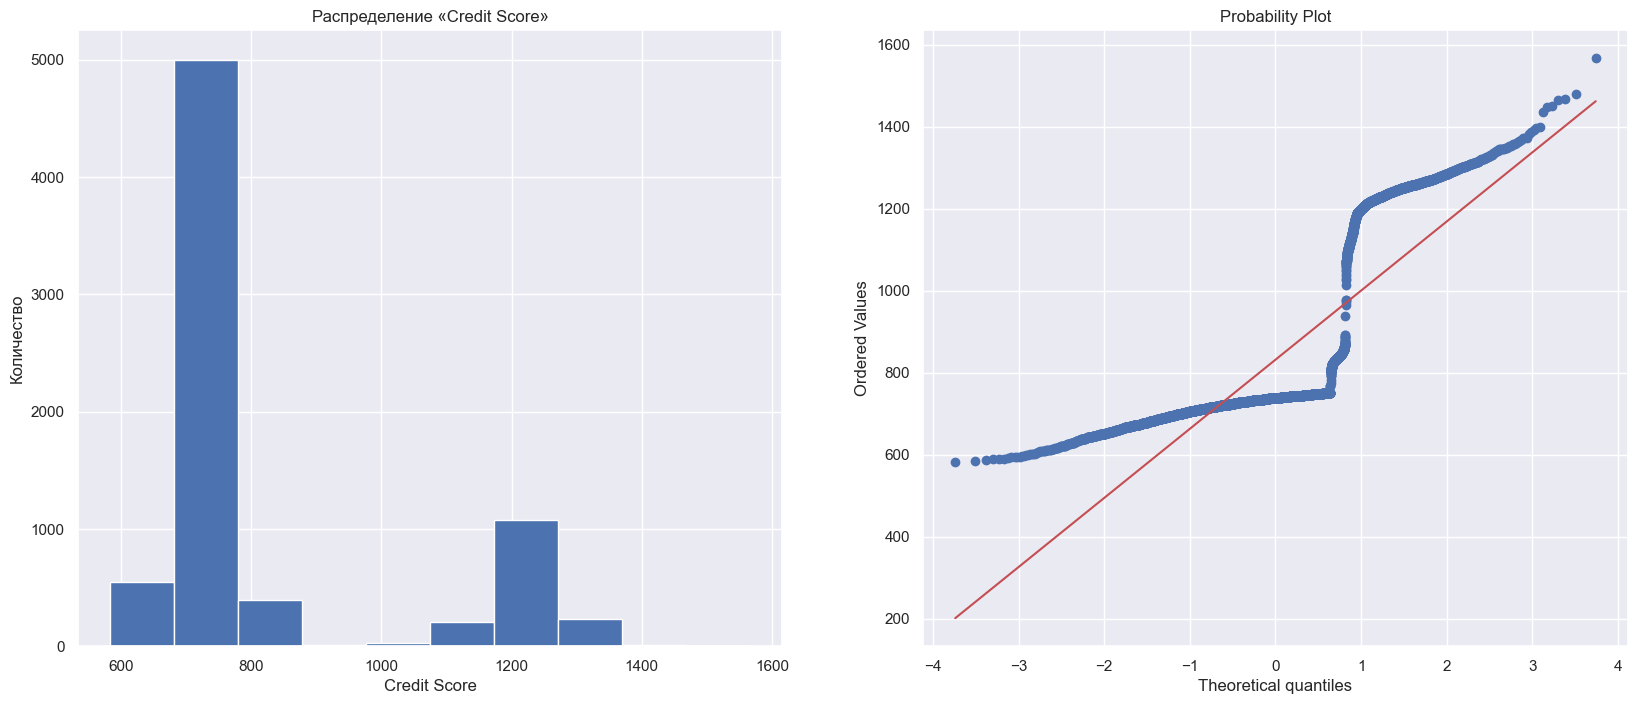

По показателю «Credit Score» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


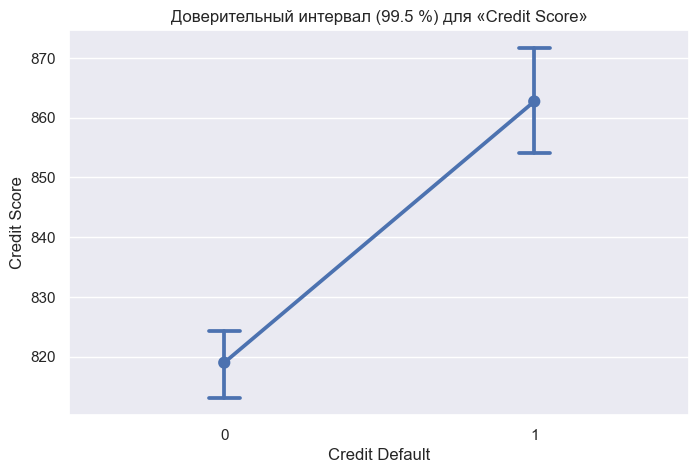

In [107]:
for cat_colname in df_train[BASE_FEATURE_NAMES].select_dtypes(include=['float64'], exclude=['object']).columns:
        if 'Tax Liens' == cat_colname or 'Number of Credit Problems' == cat_colname or 'Bankruptcies' == cat_colname:
            check_rate(df_train, TARGET_NAME, cat_colname, False)
        else:
            check_rate(df_train, TARGET_NAME, cat_colname)

### Результаты проведенного анализа

Показатели, по которым необходимо нормализовать логарифмированием:

* Maximum Open Credit
* Current Credit Balance

Показатели, которые не влияют на целевую переменную, поэтому их можно убрать:

* Bankruptcies
* Monthly Debt

Показатели, которые очень хорошо влияют на целевую переменную:

* Annual Income
* Number of Open Accounts
* Maximum Open Credit
* Months since last delinquent
* Current Loan Amount
* Credit Score

Показатели, которые менее существенно влияют на целевую переменную:

* Tax Liens
* Years of Credit History
* Number of Credit Problems
* Current Credit Balance

## 5.3 Анализ признакового пространства

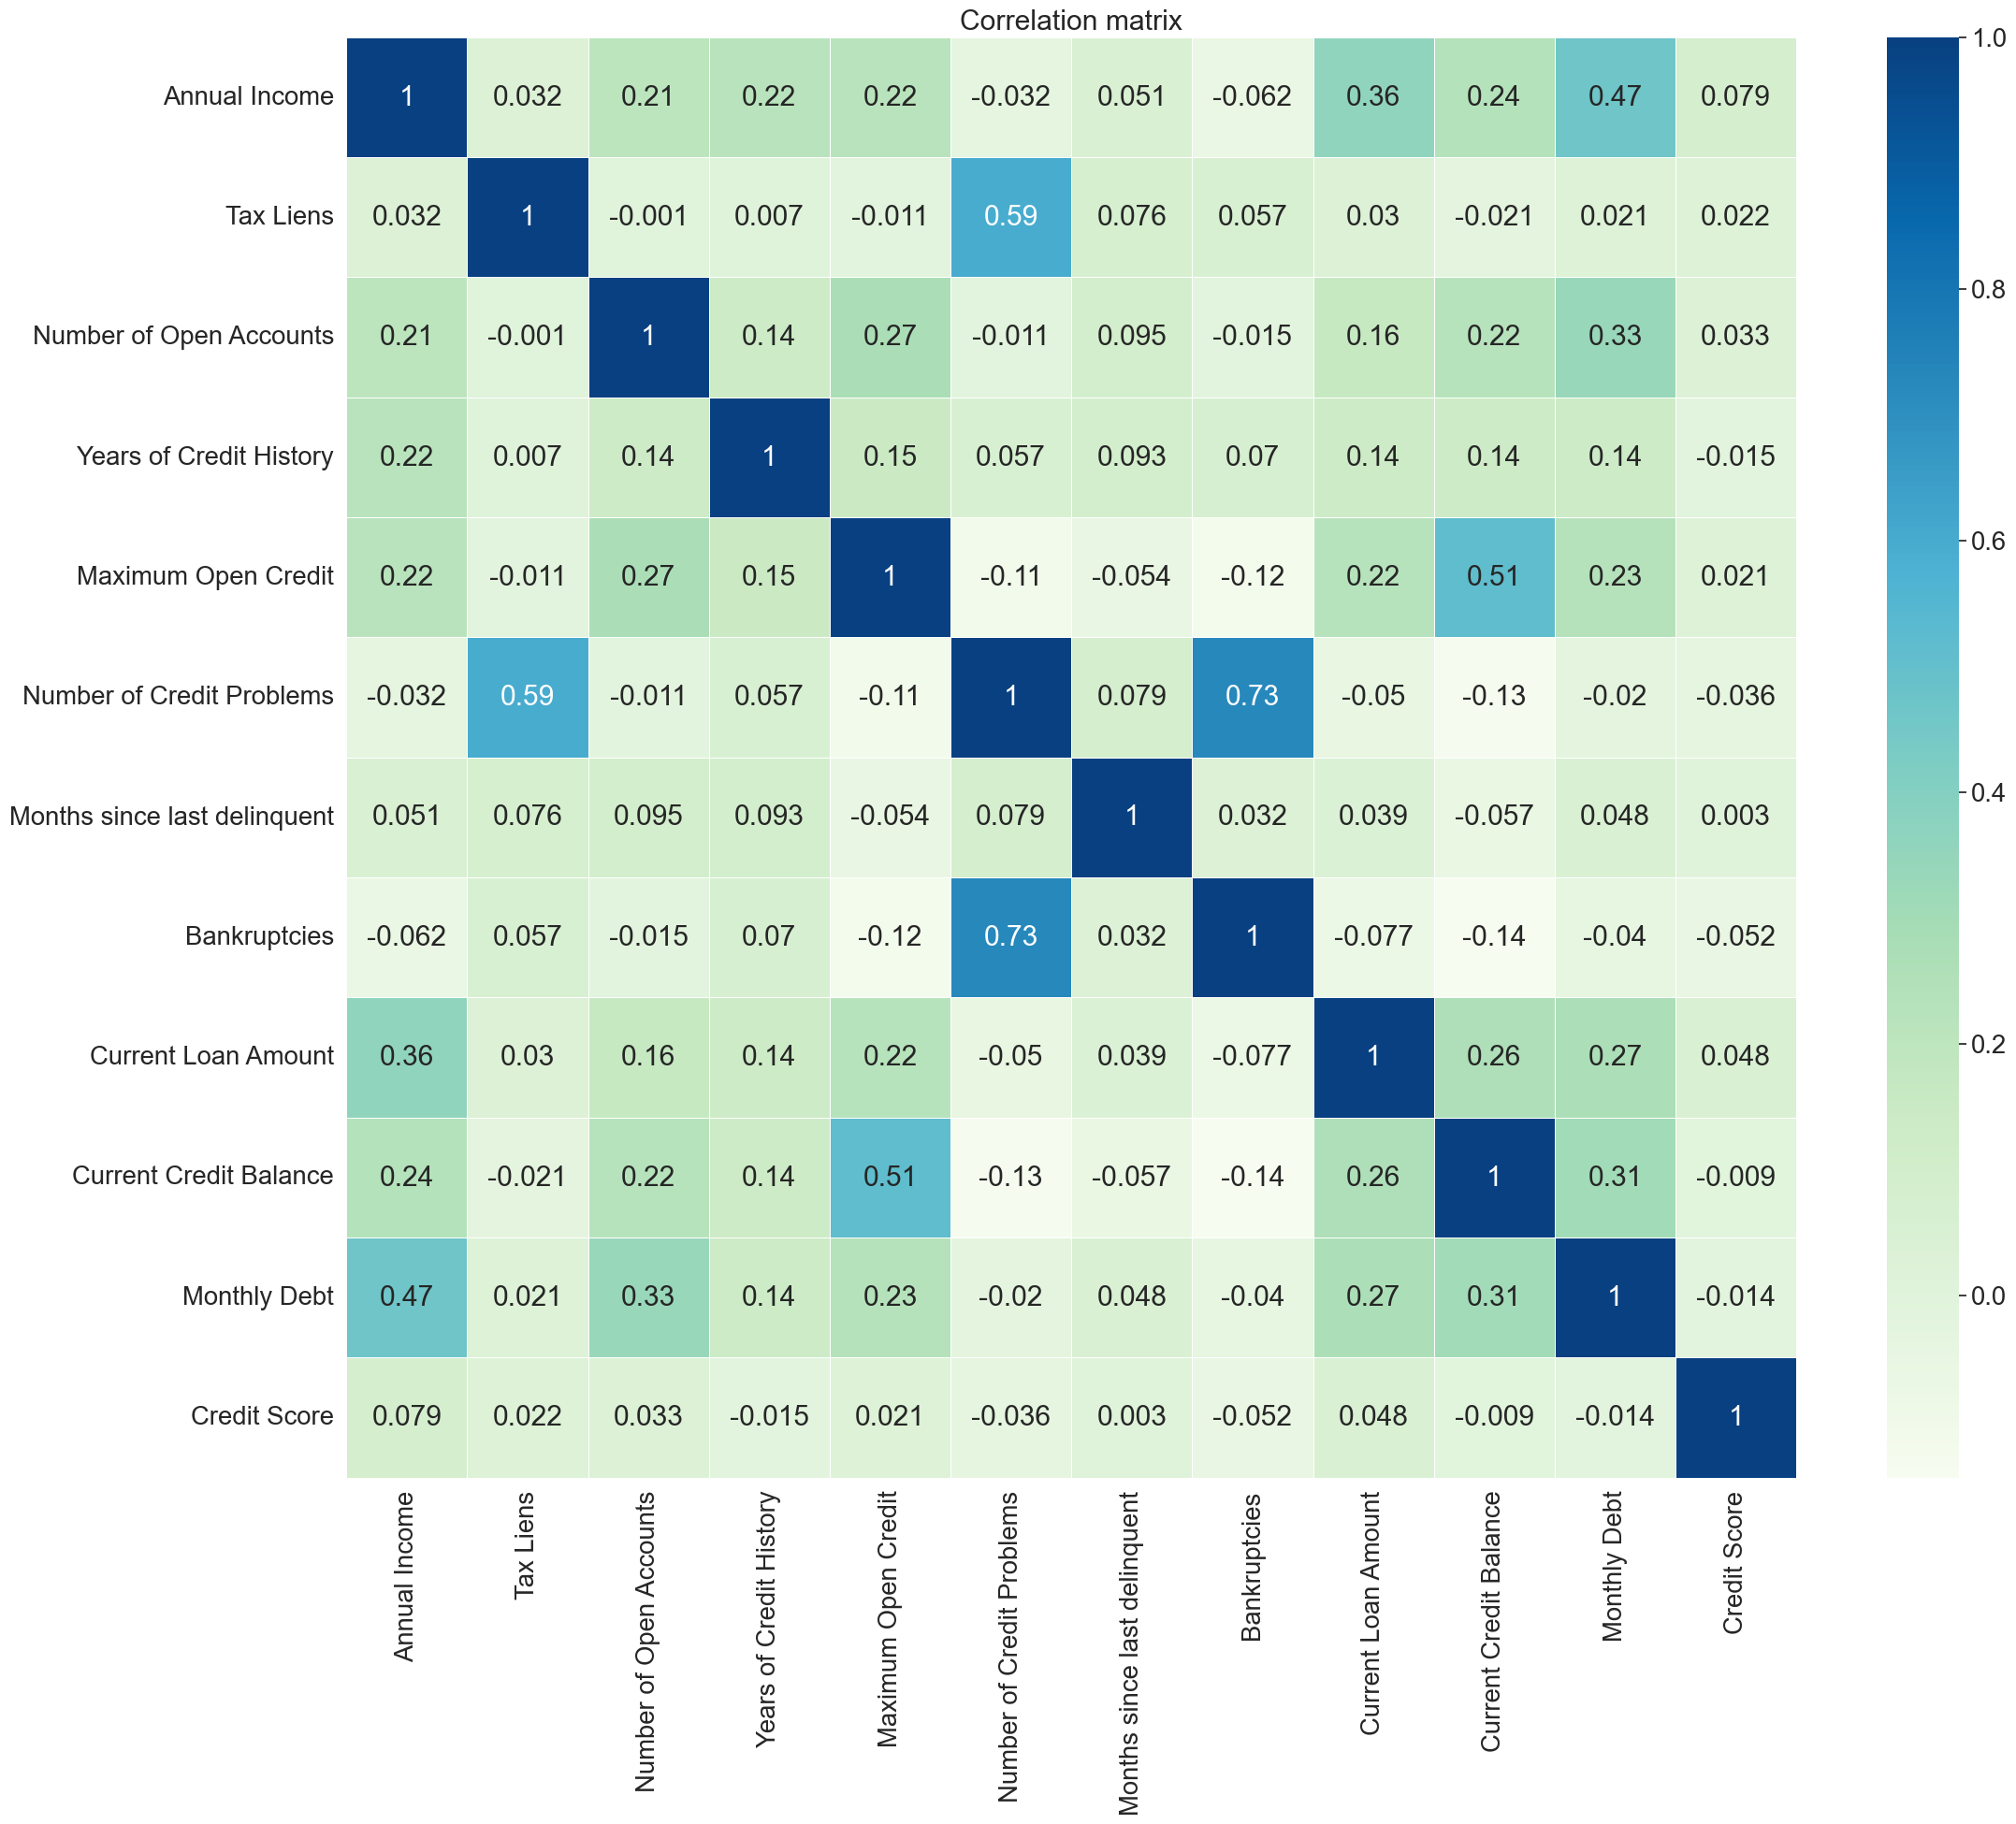

In [108]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.8)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# 6. Отбор признаков

In [109]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Credit Score',
                     'Is_Years_in_current_job']

In [110]:
CAT_FEATURE_NAMES = ['Is_Term',
                     'Is_Home_Ownership',
                     'Is_Purpose_business loan',
                     'Is_Purpose_other',
                     'Is_Purpose_small business']

In [111]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
SELECTED_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Credit Score',
 'Is_Years_in_current_job',
 'Is_Term',
 'Is_Home_Ownership',
 'Is_Purpose_business loan',
 'Is_Purpose_other',
 'Is_Purpose_small business']

### 6.1 Приведение типов для модели CatBoost

In [112]:
# for colname in CAT_FEATURE_NAMES:
#     df_train[colname] = pd.Categorical(df_train[colname])
    
# df_train[CAT_FEATURE_NAMES].dtypes

In [113]:
# for colname in CAT_FEATURE_NAMES:
#     df_test[colname] = pd.Categorical(df_test[colname])
    
# df_test[CAT_FEATURE_NAMES].dtypes

#### Результат

Приведенные типы для модели CatBoost выдали ошибку при обучение

### 6.2 Нормализация данных

In [114]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Credit Score',
                     'Is_Years_in_current_job']

In [115]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [116]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

### 6.3 Сохранение модели для нормализации данных

In [117]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### 6.4 Разбиение на train и test

In [118]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

## 7. Балансировка целевой переменной

In [119]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [120]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

**Сохранение обучающего и тестового датасетов**

In [121]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [122]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

## 8. Подбор моделей, получение бейзлана

**Логическая регрессия**

In [123]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3771
           1       0.62      0.49      0.54      2958

    accuracy                           0.64      6729
   macro avg       0.63      0.62      0.62      6729
weighted avg       0.64      0.64      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.44      0.46      0.45       634

    accuracy                           0.68      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.69      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1239  377
1                341  293


**K ближайшиз соседей**

In [124]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      3771
           1       0.77      0.67      0.72      2958

    accuracy                           0.77      6729
   macro avg       0.77      0.75      0.76      6729
weighted avg       0.77      0.77      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1616
           1       0.37      0.37      0.37       634

    accuracy                           0.64      2250
   macro avg       0.56      0.56      0.56      2250
weighted avg       0.64      0.64      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1217  399
1                400  234


**Бустинговые алгориты**

* XGBoost

In [125]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3771
           1       0.99      0.98      0.99      2958

    accuracy                           0.99      6729
   macro avg       0.99      0.99      0.99      6729
weighted avg       0.99      0.99      0.99      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1616
           1       0.52      0.45      0.48       634

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1356  260
1                350  284


* LightGBM

In [126]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2958, number of negative: 3771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 6729, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439590 -> initscore=-0.242827
[LightGBM] [Info] Start training from score -0.242827
TRAIN

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3771
           1       0.95      0.89      0.92      2958

    accuracy                           0.93      6729
   macro avg       0.94      0.93      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision  

* CatBoost

In [127]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3771
           1       0.95      0.83      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.90      0.90      6729
weighted avg       0.91      0.91      0.90      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.47      0.51       634

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1377  239
1                338  296


## 9. Выбор наилучшей модели и настройка гиперпараметров

In [128]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

### 9.1 Подбор параметров

In [129]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth':[3, 5, 7]}

In [130]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [131]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 33.1 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002DF45086F70>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [132]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 3}

In [133]:
rs.best_score_

0.5379241414495864

**Обучение и оценка финальной модели**

In [134]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3771
           1       0.80      0.64      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.78      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1616
           1       0.55      0.51      0.53       634

    accuracy                           0.75      2250
   macro avg       0.68      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1354  262
1                311  323
Wall time: 5.63 s


## 10. Проверка качества, борьба с переобучением

In [135]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      3771
           1       0.84      0.70      0.76      2958

    accuracy                           0.81      6729
   macro avg       0.81      0.80      0.80      6729
weighted avg       0.81      0.81      0.81      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1343  273
1                309  325


**Подбор оптимального размера выборки. Построение кривой обучения**

In [136]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)


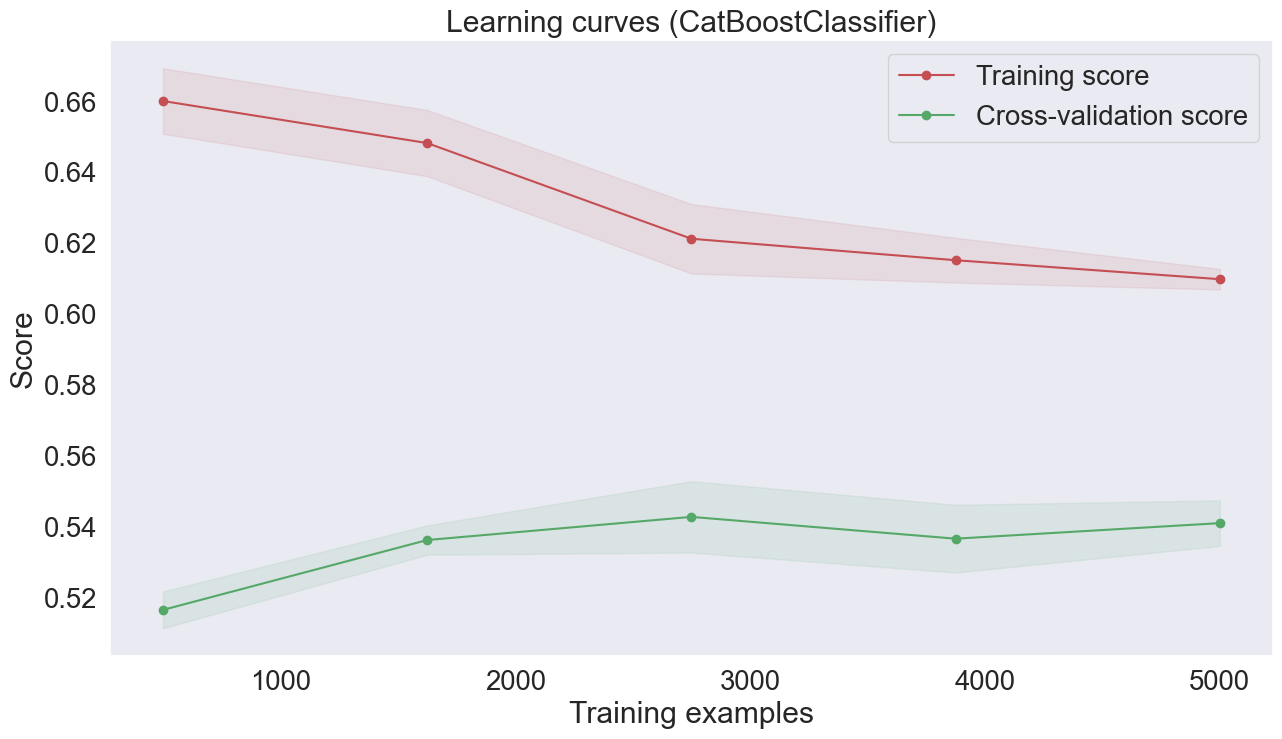

In [137]:
show_learning_curve_plot(final_model, X, y)

**Выбор порога вероятности для определения класса**

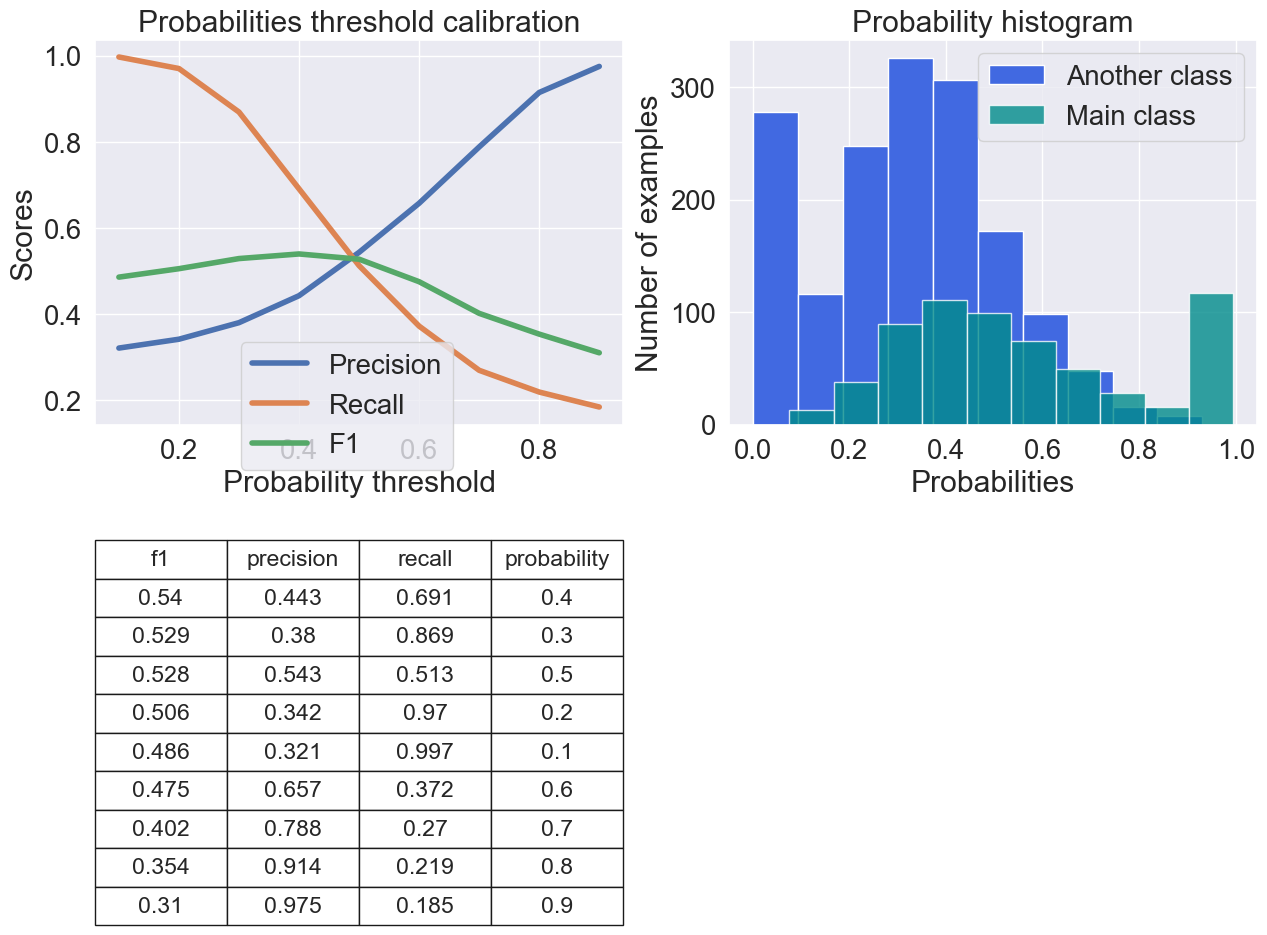

In [138]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Определение важности признаков**

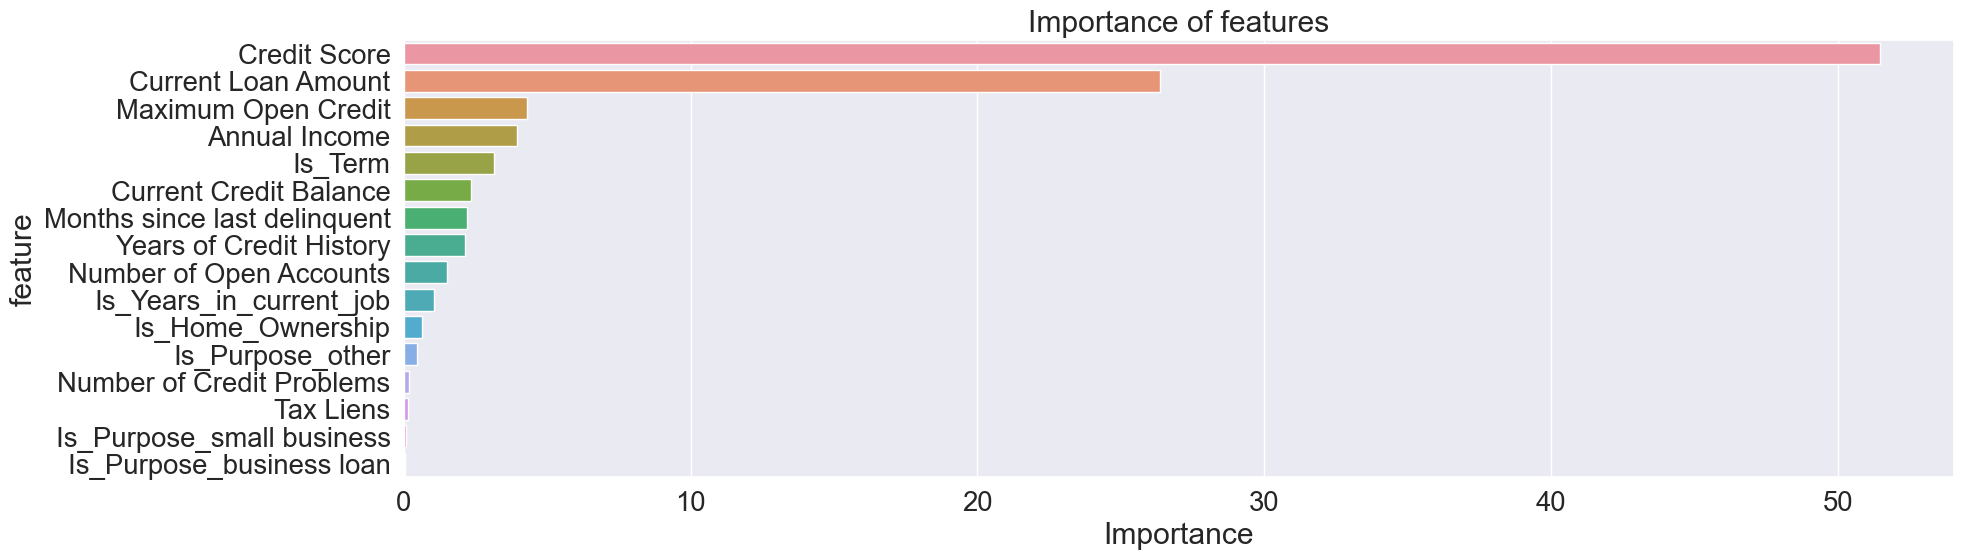

In [139]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

In [140]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Maximum Open Credit',
 'Annual Income',
 'Is_Term',
 'Current Credit Balance',
 'Months since last delinquent',
 'Years of Credit History',
 'Number of Open Accounts',
 'Is_Years_in_current_job']

**Финальная модель**

In [141]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      3771
           1       0.84      0.70      0.76      2958

    accuracy                           0.81      6729
   macro avg       0.81      0.80      0.80      6729
weighted avg       0.81      0.81      0.81      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1616
           1       0.56      0.52      0.54       634

    accuracy                           0.75      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.74      0.75      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1352  264
1                303  331


**Сохранение финальной модели**

In [142]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## 11. Интерпретация результатов

In [143]:
y_result = final_model.predict(df_test[important_features_top])

In [144]:
result = pd.DataFrame({'ID': df_test['ID'], 'Credit Default': y_result})

In [145]:
result['Credit Default'].value_counts()

0    1918
1     582
Name: Credit Default, dtype: int64

In [146]:
result.to_csv(RESULT_FILE_PATH, index=False, encoding='utf-8')